Using the CIFAR10 data provided below, create an alogrithm that takes in a gray scale image and coverts it to a color image.

Note for this problem we will define the grayscale image as the average of the three color channels.

# Approaches

- ## Conditional GANs
The approach here was to tackle the problem in the follownig architecture: generator gets a noise concatenated with one-dimensional gray image passed as the condition, the discriminator is passed real images concatenated with the condition and then the fake images concatenated with the condition.

Findings: the model went through two main problems
- The discriminator converged very fast, with the generator's loss steadily increasing, signifying that the generator is not leanrning fast enough and discriminator's task is too easy.
- The loss of the generator was expanding over epochs, regardless of learning rate changes and optimization method changes.

The approach to resolve these problems was as follows:
- Introducing more complexity to the discriminator, by smoothing the labels; a technique shown to be effective in literature.
- Introducing extra level of complexity to the environment, by noisy labels; a technique where true labels are switched to fake intentionally to reduce the convergence rate of discriminator.
- Decrease the amount of stochasticity to the generator, by normalizing the noise and reducing the variance.

Cont. Findings: the model measures of losses improved, but as a preliminary hypothesis, the model is not performing well due to artchitectural issues and further hyperparameters tuning.
- ## AutoEncoders
Due to limited time, a less efficient but effective nonetheless model is AE. A simple encoder-decoder architecture was proposed with two convolutional layers followed by two transposed convolutional networks.

Findings: The performance is slightly blurry, a more accurate model would encapsulate different hyperparameters and improved architecture. However, I believe that the task is simple and an AE model would only do so much.

# **Conditional Image Generation**

## Import Libraries

In [ ]:
from torchvision.datasets import CIFAR10
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Lambda, Grayscale, Normalize
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import numpy as np
from PIL import Image

## Define Hyperparameters

In [ ]:
EPOCHS = 60
LEARNING_RATE = 5e-4
BATCH_SIZE = 32
Z = 16

## Data Preparation

In [ ]:
transform_steps = Compose([
            ToTensor(),
            Lambda(lambda t: (t * 2) - 1)
])

In [ ]:
# We will be using the cifar10 data.
train_data = CIFAR10(root='cifar_data/', train=True, download=True, transform=transform_steps)
cifar_dataset = datasets.CIFAR10(root="cifar_data/", download=True, transform=transform_steps)

# Initializing pytorch dataloader
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Data Visualization

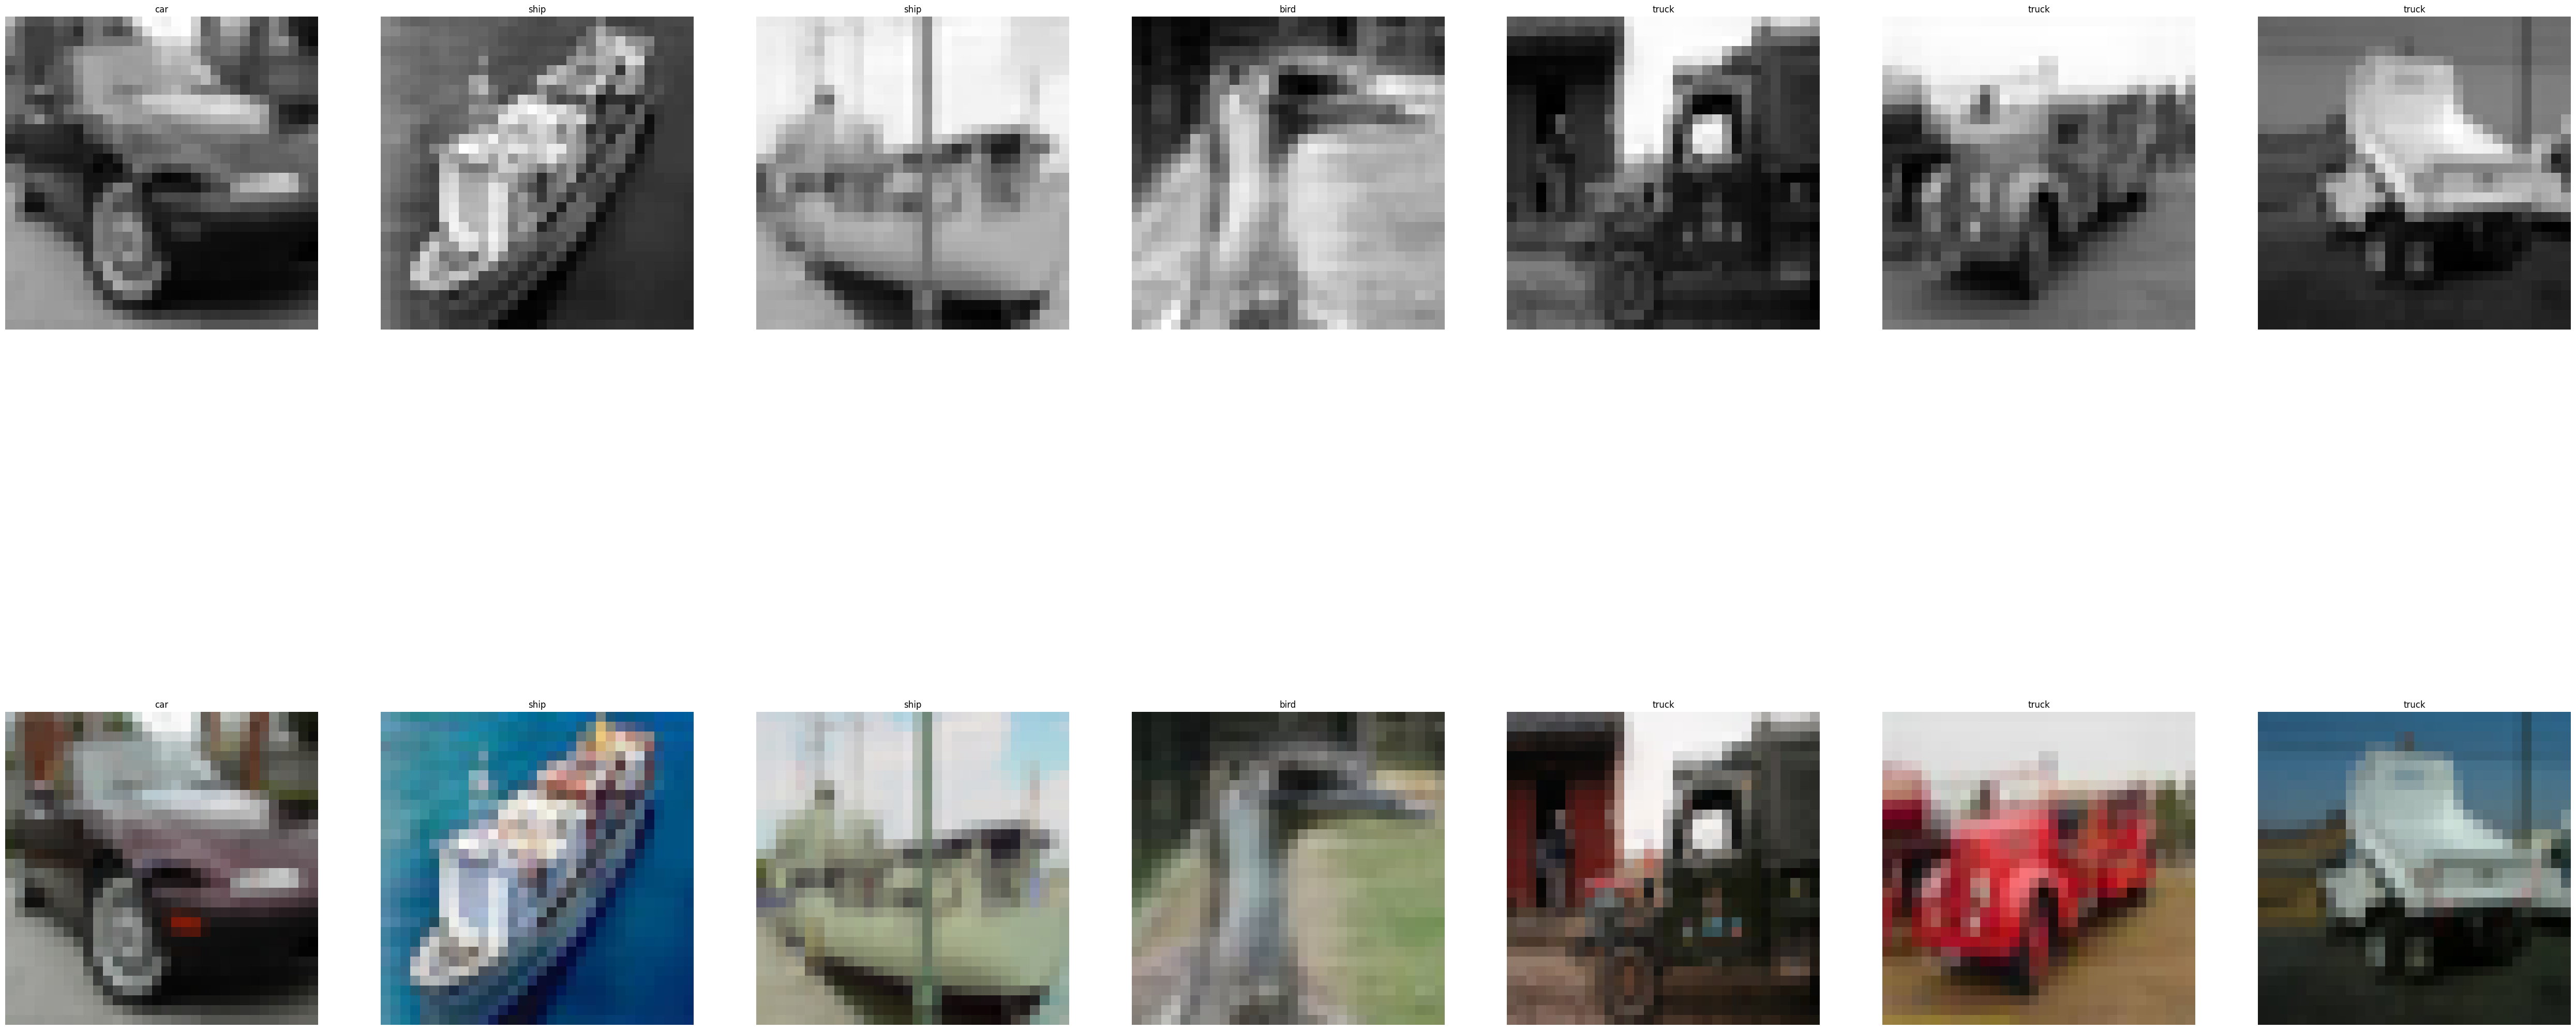

In [ ]:
# Visualizing some sample images
figure = plt.figure(figsize=(64, 64))
cols, rows = 7, 2
for i in range(1, cols + 1):

    sample_idx = torch.randint(len(cifar_dataset), size=(1,)).item()
    img, label = cifar_dataset[sample_idx]
    img = (img/2)+0.5
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    image_gray = torch.mean(img, dim=0, keepdim=True)
    plt.imshow(image_gray.permute((1,2,0)), cmap='gray')
    rows -= 1

    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.permute((1,2,0)))

    rows += 1


plt.show()


## Define Helper Classes and Model Classes

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class Reshape(nn.Module):
  """A custom reshape layer."""
  def __init__(self, shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(*self.shape)

class Print_shape(nn.Module):
  """A custom reshape layer."""
  def __init__(self):
    super().__init__()

  def forward(self, x):
    print(x.shape)
    return x


def weights_init(m):
    """Reinitialize model weights. GAN authors recommend them to be sampled from N(0,0.2)"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
  """Generator model"""
  def __init__(self, z):
    super(Generator, self).__init__()
    self.z = z
    self.gen_model_down = nn.Sequential(

        nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),

        nn.Flatten(1,-1),
        nn.Linear(256 * 2 * 2, z),
        nn.BatchNorm1d(z),
        nn.LeakyReLU(),

        nn.Linear(z, 256 * 2 * 2),
        nn.BatchNorm1d(256 * 2 * 2),
        nn.LeakyReLU(),


    )
    self.gen_model_up = nn.Sequential(
        nn.Unflatten(1, (256, 2, 2)),

        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(in_channels=128, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.Tanh(),
    )

  def forward(self, x, condition):

    x = torch.cat([x,condition], 1)
    x = self.gen_model_down(x)
    x = self.gen_model_up(x)

    return x


class Discriminator(nn.Module):
  """Discriminator model"""
  def __init__(self):
    super(Discriminator, self).__init__()
    self.disc_model = nn.Sequential(
        nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),

    )

    self.flatten = nn.Flatten(1,-1)
    self.layer_1 = nn.Linear(256 * 2 * 2, 128)
    self.layer_1_b = nn.BatchNorm1d(128)
    self.layer_1_a = nn.LeakyReLU()

    self.layer_2 = nn.Linear(128, 32)
    self.layer_2_b = nn.BatchNorm1d(32)
    self.layer_2_a = nn.LeakyReLU()

    self.layer_3 = nn.Linear(32, 1)
    self.layer_3_a = nn.Sigmoid()

  def forward(self, x, condition):

    x = torch.cat([x,condition], 1)
    x = self.disc_model(x)

    x = self.flatten(x)
    x = self.layer_1_a(self.layer_1_b(self.layer_1(x)))
    x = self.layer_2_a(self.layer_2_b(self.layer_2(x)))
    x = self.layer_3_a(self.layer_3(x))
    return x


discriminator = Discriminator()
discriminator.apply(weights_init)
discriminator.to(device)
generator = Generator(z=Z)
generator.apply(weights_init)
generator.to(device)


## Instantiate Optimizers

In [ ]:
# Defining the optimizer and loss function here
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE*0.001,betas=(0.5, 0.999))
loss_fn = nn.BCELoss()

## Define Helper Methods for Label Manipulation

In [ ]:
def smooth_labels(y, is_real, smoothing_factor=0.3):
    if is_real: # real sample
        return y - np.random.uniform(0, smoothing_factor)
    else: # fake sample
        return y + np.random.uniform(0, smoothing_factor)

def noisy_labels(y, flip_ratio=0.05):
    n_select = int(flip_ratio * len(y))
    flip_indices = np.random.choice(len(y), size=n_select)
    y[flip_indices] = 1 - y[flip_indices]
    return y

## Helper Method for Image Diplay

In [ ]:
# Helper function to display results
def display_image_grid(images, labels, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im, l in zip(grid, images, labels):
        ax.imshow(im.permute(1,2,0))

        ax.axis("off")
        ax.set_title(classes[l])

    plt.suptitle(title_text, fontsize=20)
    plt.show()

## Noise reshaping NN

In [ ]:
class NoiseEnlarger(nn.Module):
  """Noise model"""
  def __init__(self):
    super(NoiseEnlarger, self).__init__()
    self.linear = nn.Linear(32, 32*32)
  def forward(self, x):
    x = self.linear(x).view(-1, 1, 32, 32)
    return x

noise_enr = NoiseEnlarger().to(device)


## Define Constants and Start Training Loop

Epoch 1/60: : 100%|██████████| 1563/1563 [01:02<00:00, 24.91it/s, generator_loss=0.802, discriminator_loss=1.54, D(x)=0.364, D(G(z1))=0.443, D(G(z2))=0.443]


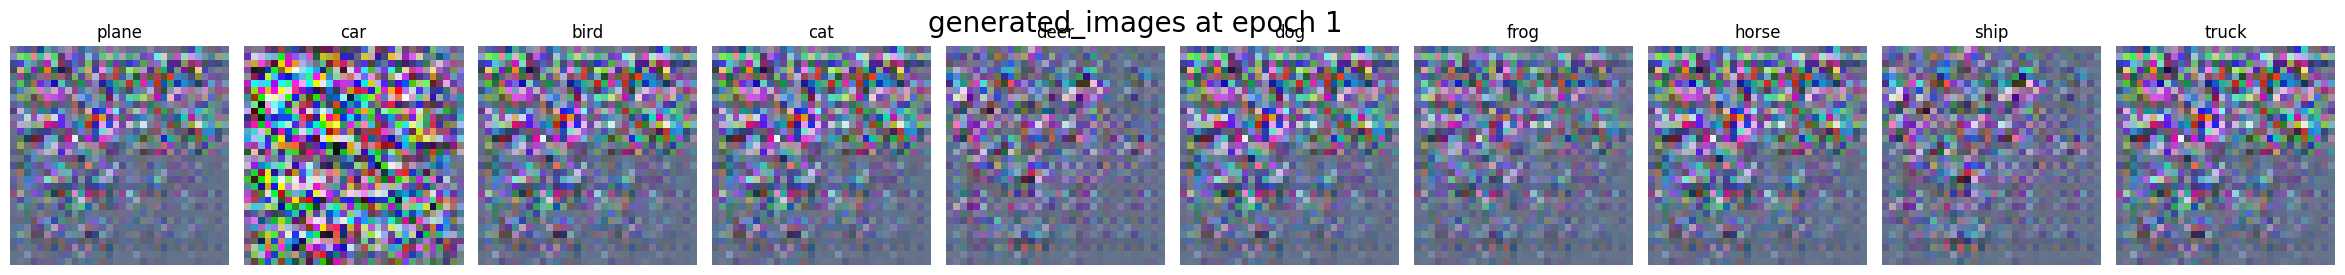

Epoch 2/60: : 100%|██████████| 1563/1563 [01:08<00:00, 22.89it/s, generator_loss=0.819, discriminator_loss=1.54, D(x)=0.372, D(G(z1))=0.437, D(G(z2))=0.437]


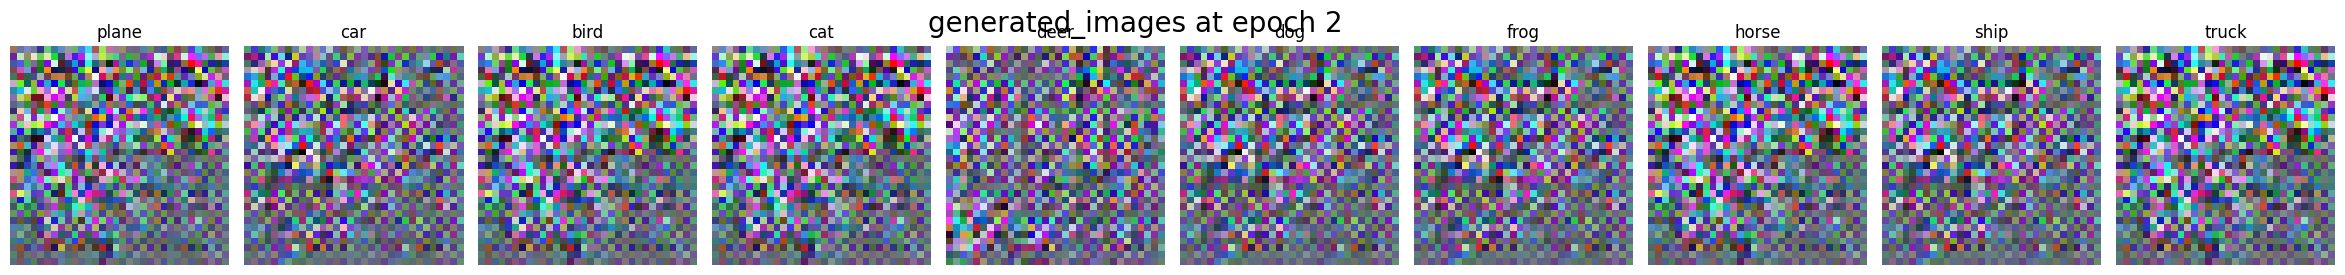

Epoch 3/60: : 100%|██████████| 1563/1563 [01:08<00:00, 22.80it/s, generator_loss=0.776, discriminator_loss=1.49, D(x)=0.371, D(G(z1))=0.452, D(G(z2))=0.452]


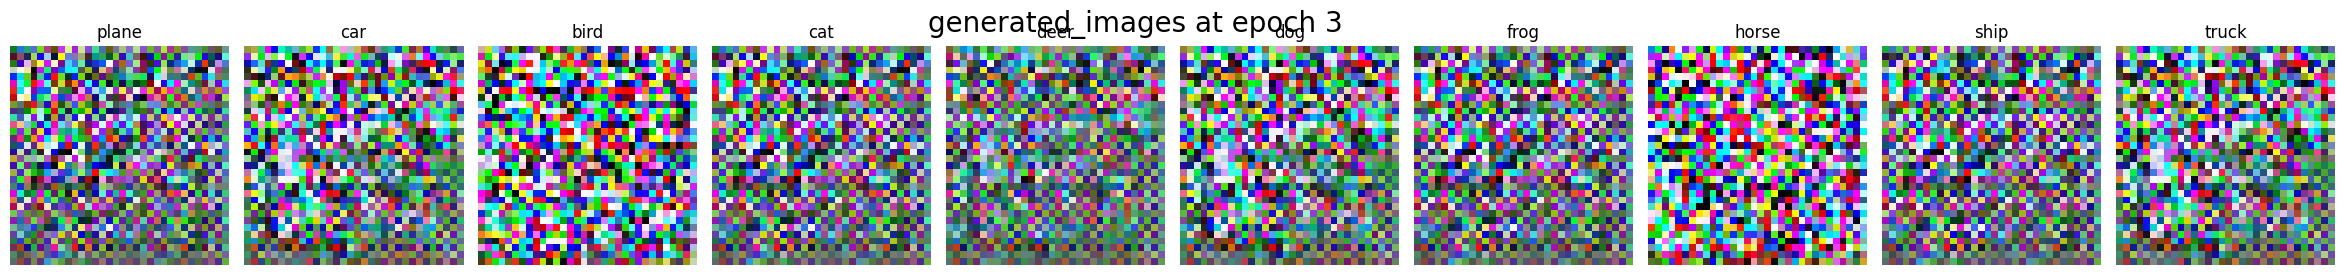

Epoch 4/60: : 100%|██████████| 1563/1563 [01:09<00:00, 22.40it/s, generator_loss=0.832, discriminator_loss=1.6, D(x)=0.377, D(G(z1))=0.434, D(G(z2))=0.434]


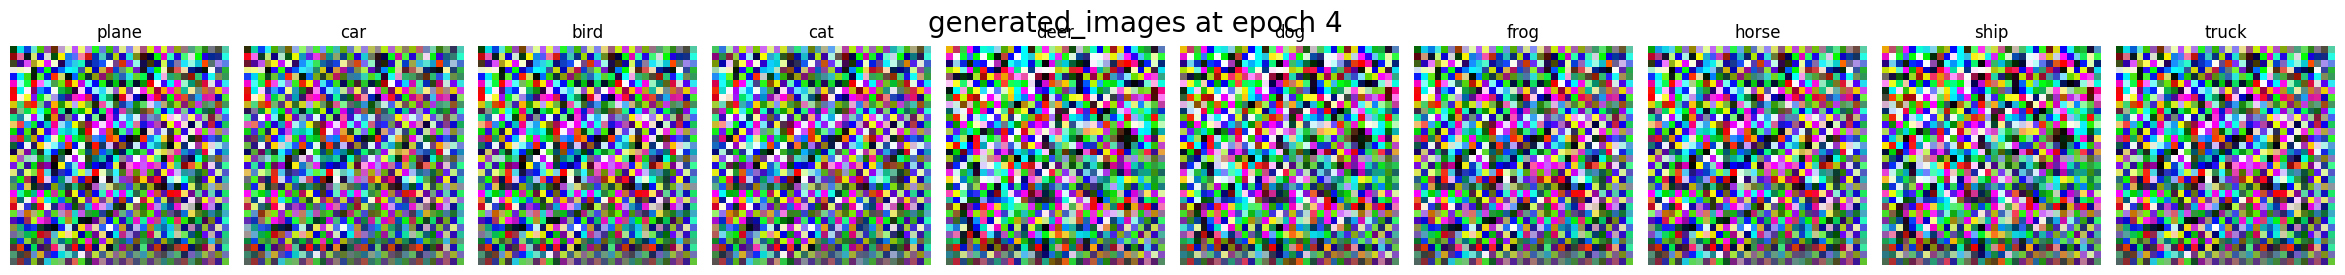

Epoch 5/60: : 100%|██████████| 1563/1563 [01:11<00:00, 21.94it/s, generator_loss=0.954, discriminator_loss=1.35, D(x)=0.386, D(G(z1))=0.387, D(G(z2))=0.386]


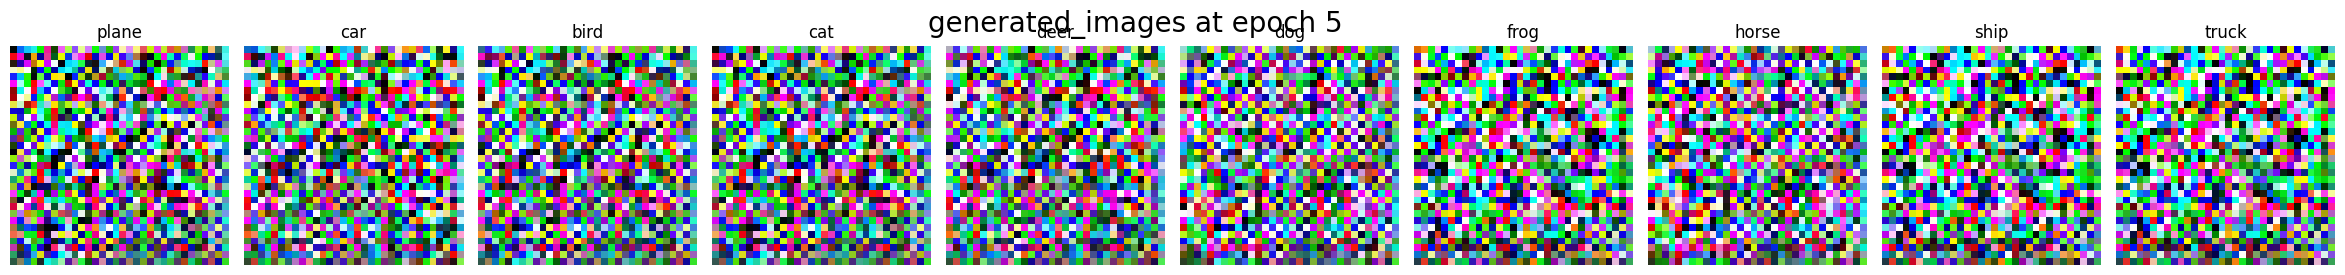

Epoch 6/60: : 100%|██████████| 1563/1563 [01:13<00:00, 21.16it/s, generator_loss=0.819, discriminator_loss=1.54, D(x)=0.386, D(G(z1))=0.433, D(G(z2))=0.433]


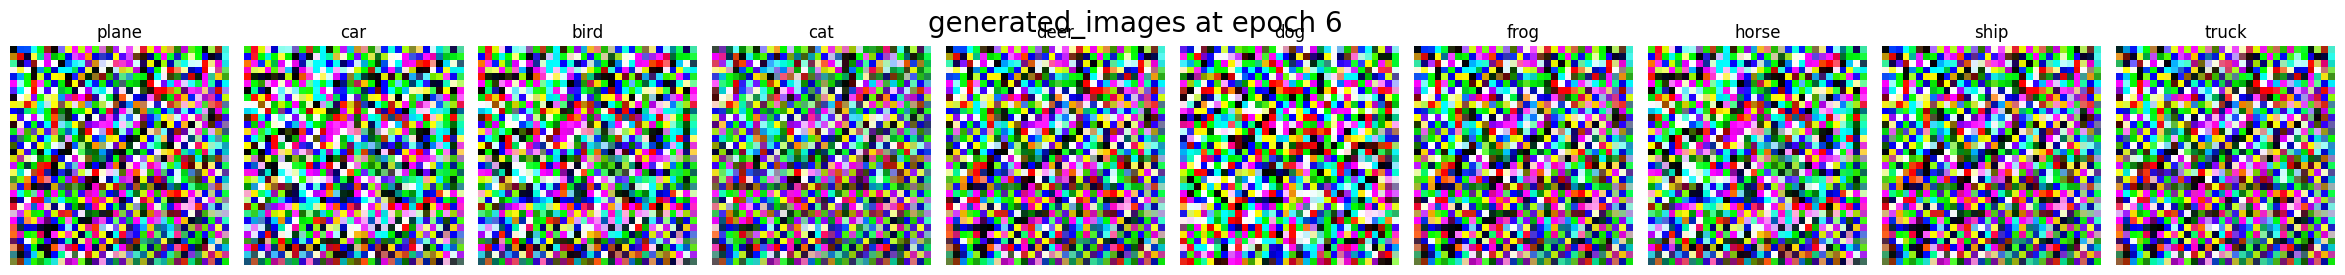

Epoch 7/60: : 100%|██████████| 1563/1563 [01:14<00:00, 21.12it/s, generator_loss=0.754, discriminator_loss=1.46, D(x)=0.405, D(G(z1))=0.45, D(G(z2))=0.45]


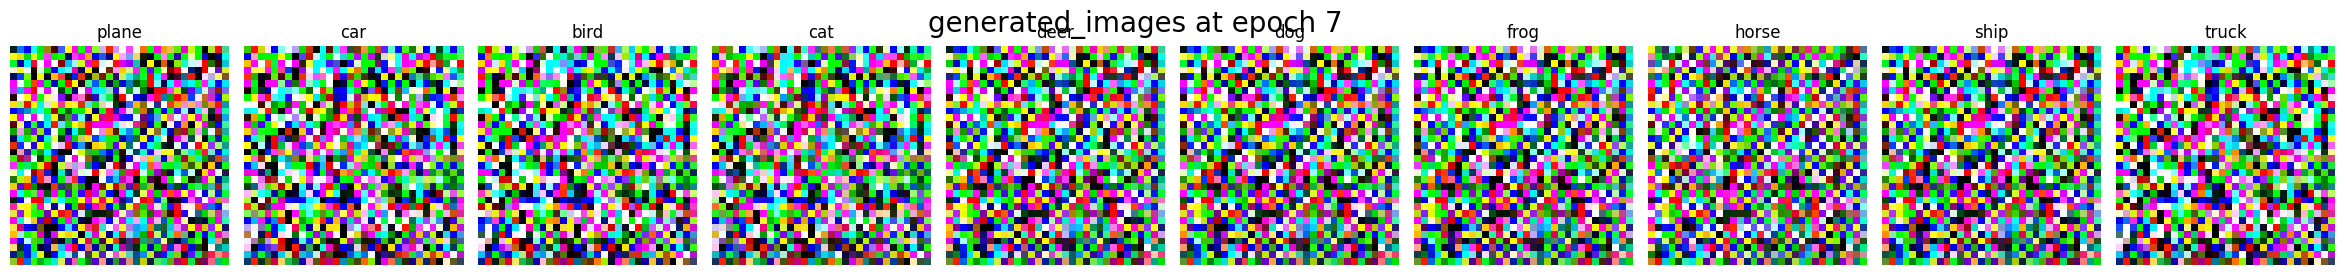

Epoch 8/60: : 100%|██████████| 1563/1563 [01:12<00:00, 21.46it/s, generator_loss=0.81, discriminator_loss=1.51, D(x)=0.393, D(G(z1))=0.429, D(G(z2))=0.428]


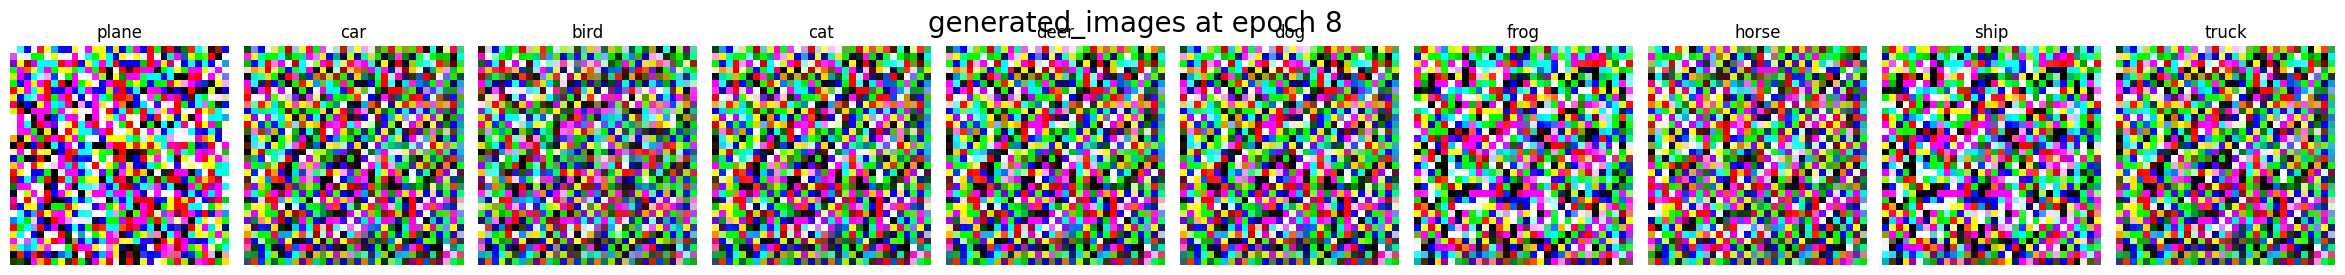

Epoch 9/60: : 100%|██████████| 1563/1563 [01:17<00:00, 20.21it/s, generator_loss=0.849, discriminator_loss=1.49, D(x)=0.412, D(G(z1))=0.427, D(G(z2))=0.426]


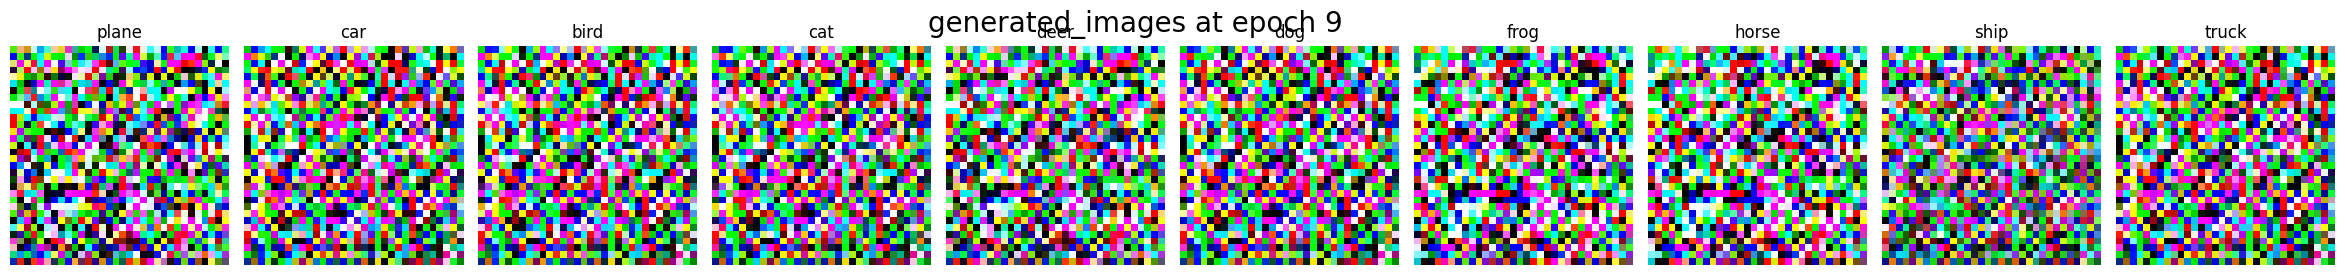

Epoch 10/60: : 100%|██████████| 1563/1563 [01:16<00:00, 20.50it/s, generator_loss=0.881, discriminator_loss=1.43, D(x)=0.4, D(G(z1))=0.418, D(G(z2))=0.418]


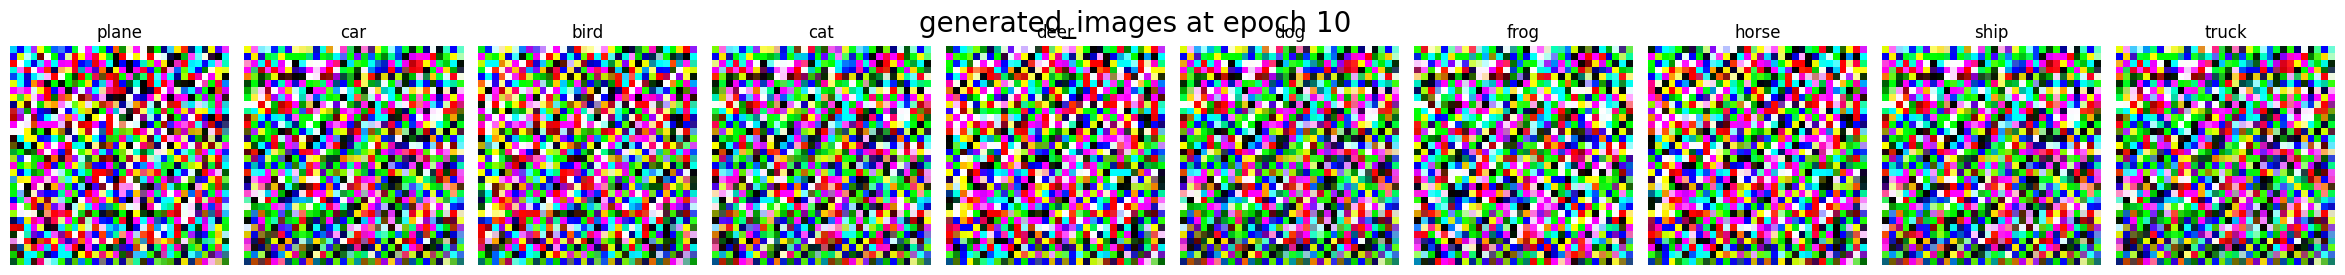

Epoch 11/60: : 100%|██████████| 1563/1563 [01:13<00:00, 21.13it/s, generator_loss=0.791, discriminator_loss=1.51, D(x)=0.412, D(G(z1))=0.434, D(G(z2))=0.434]


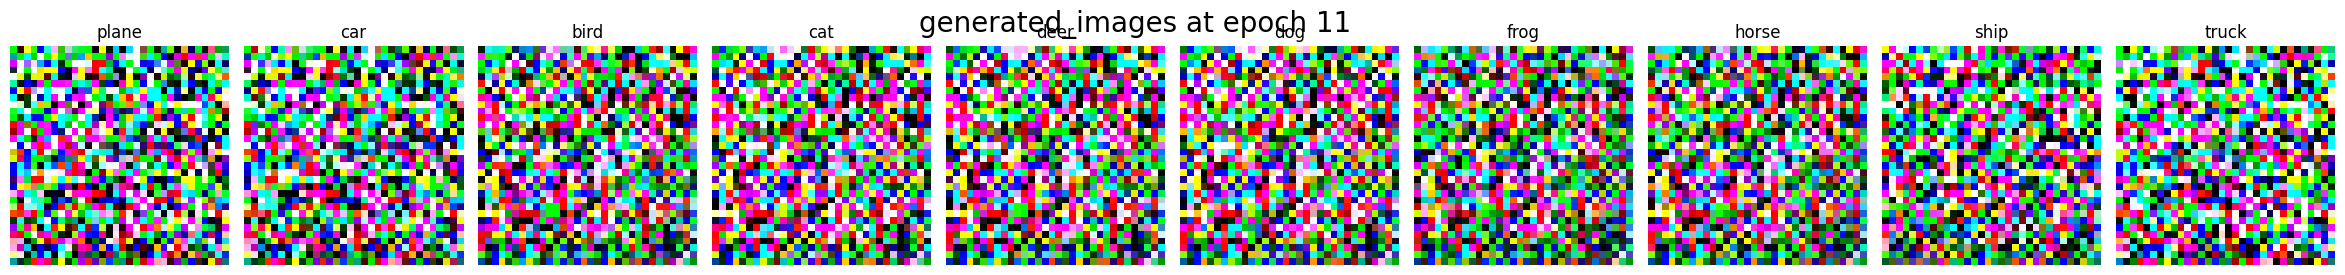

Epoch 12/60: : 100%|██████████| 1563/1563 [01:14<00:00, 21.00it/s, generator_loss=0.765, discriminator_loss=1.42, D(x)=0.426, D(G(z1))=0.45, D(G(z2))=0.449]


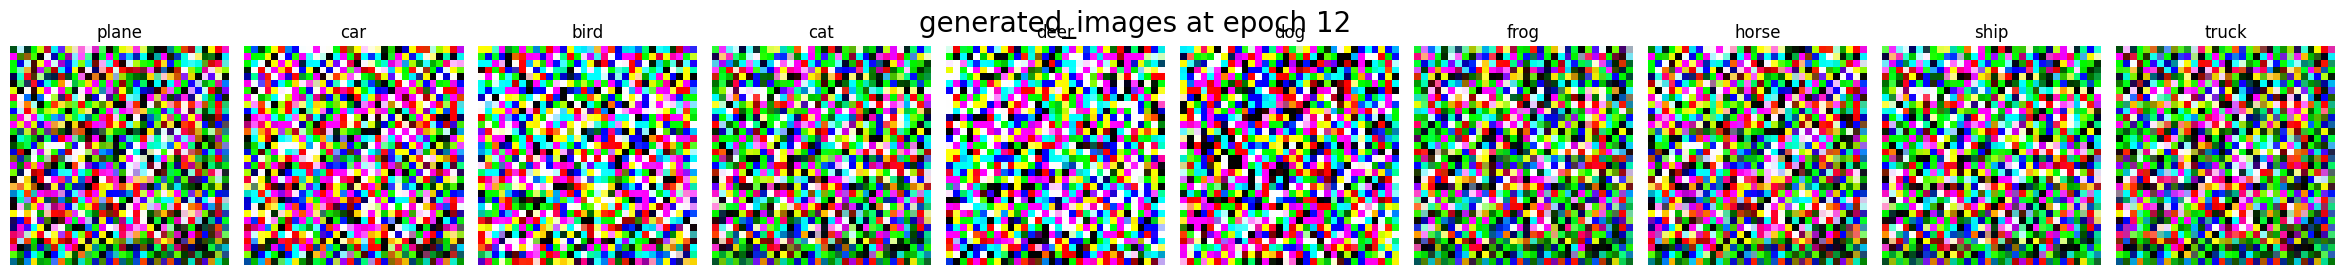

Epoch 13/60: : 100%|██████████| 1563/1563 [01:13<00:00, 21.29it/s, generator_loss=0.749, discriminator_loss=1.49, D(x)=0.408, D(G(z1))=0.459, D(G(z2))=0.459]


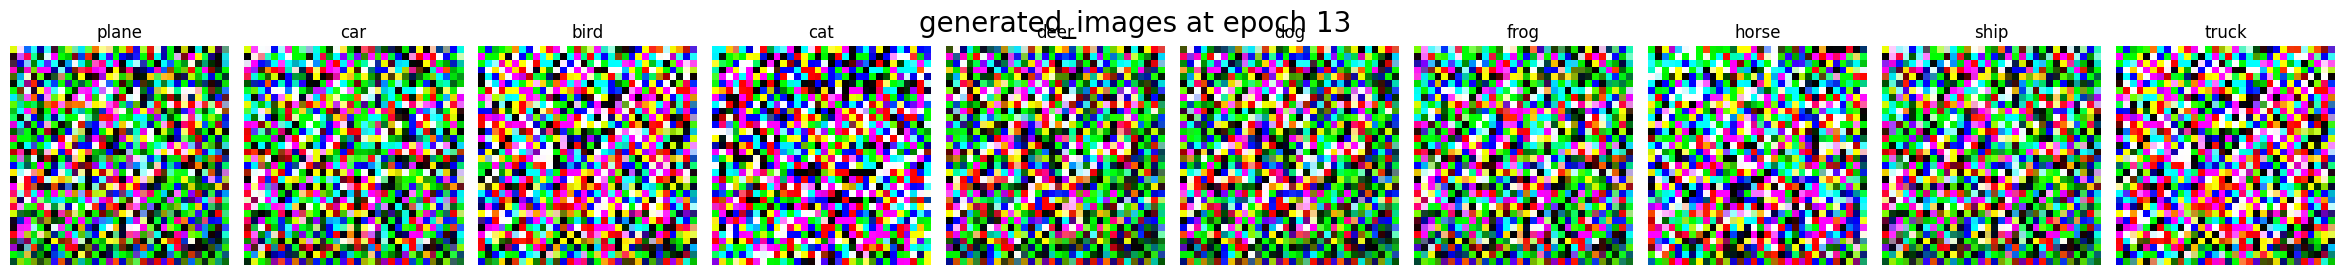

Epoch 14/60: : 100%|██████████| 1563/1563 [01:18<00:00, 20.02it/s, generator_loss=0.737, discriminator_loss=1.45, D(x)=0.43, D(G(z1))=0.466, D(G(z2))=0.466]


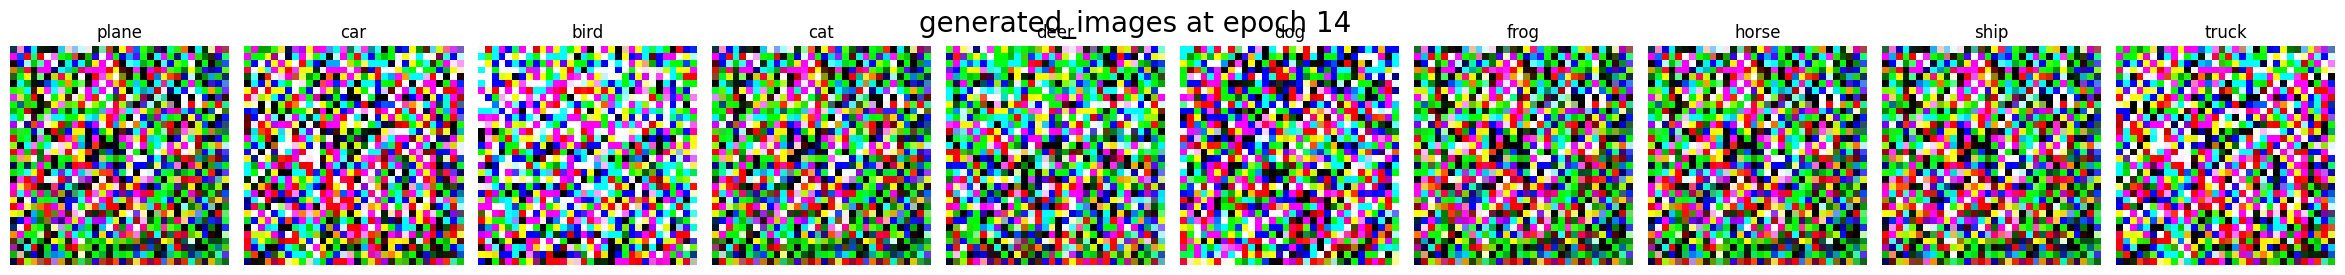

Epoch 15/60: : 100%|██████████| 1563/1563 [01:15<00:00, 20.58it/s, generator_loss=0.767, discriminator_loss=1.4, D(x)=0.443, D(G(z1))=0.463, D(G(z2))=0.463]


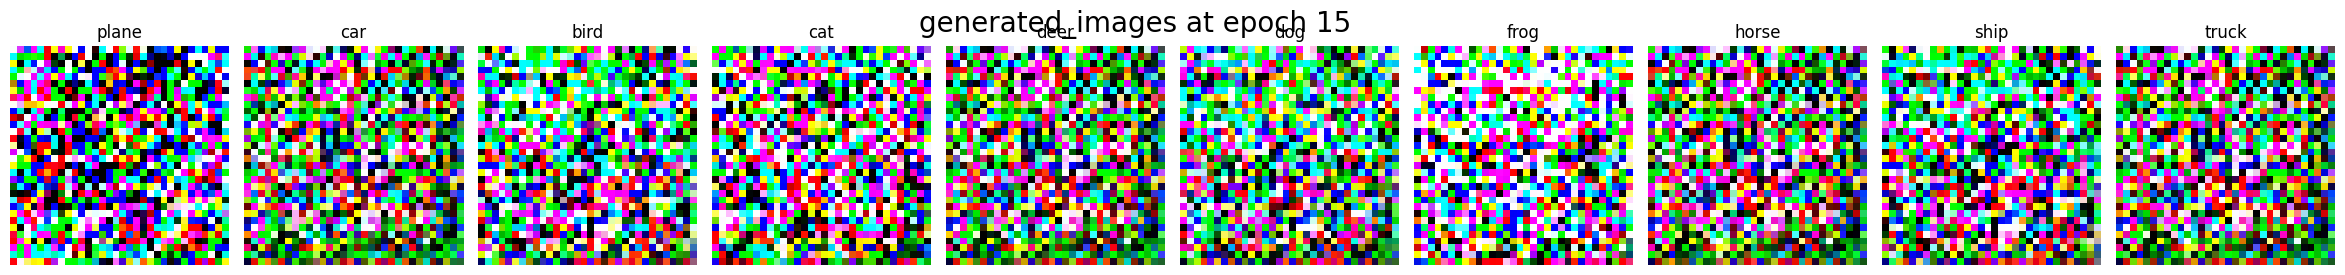

Epoch 16/60: : 100%|██████████| 1563/1563 [01:16<00:00, 20.31it/s, generator_loss=0.756, discriminator_loss=1.42, D(x)=0.434, D(G(z1))=0.453, D(G(z2))=0.453]


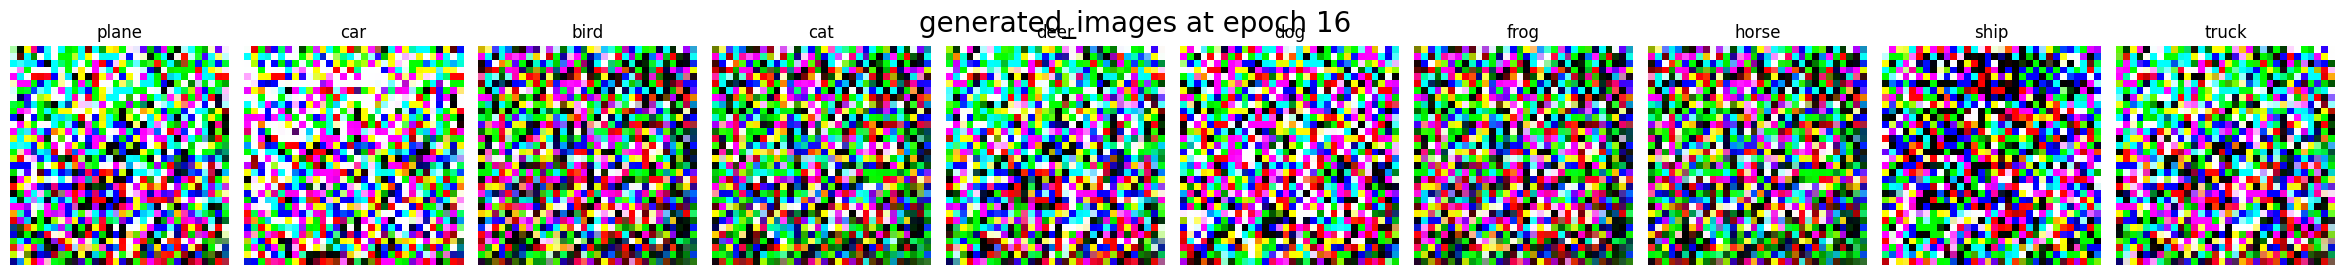

Epoch 17/60: : 100%|██████████| 1563/1563 [01:15<00:00, 20.63it/s, generator_loss=0.767, discriminator_loss=1.44, D(x)=0.431, D(G(z1))=0.445, D(G(z2))=0.445]


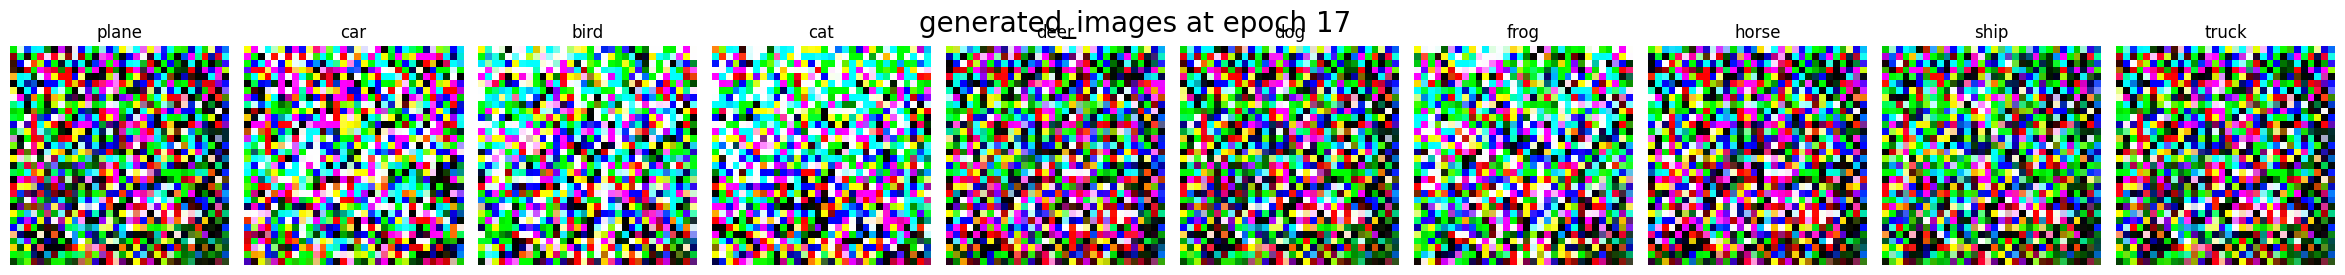

Epoch 18/60: : 100%|██████████| 1563/1563 [01:16<00:00, 20.52it/s, generator_loss=0.798, discriminator_loss=1.41, D(x)=0.435, D(G(z1))=0.434, D(G(z2))=0.434]


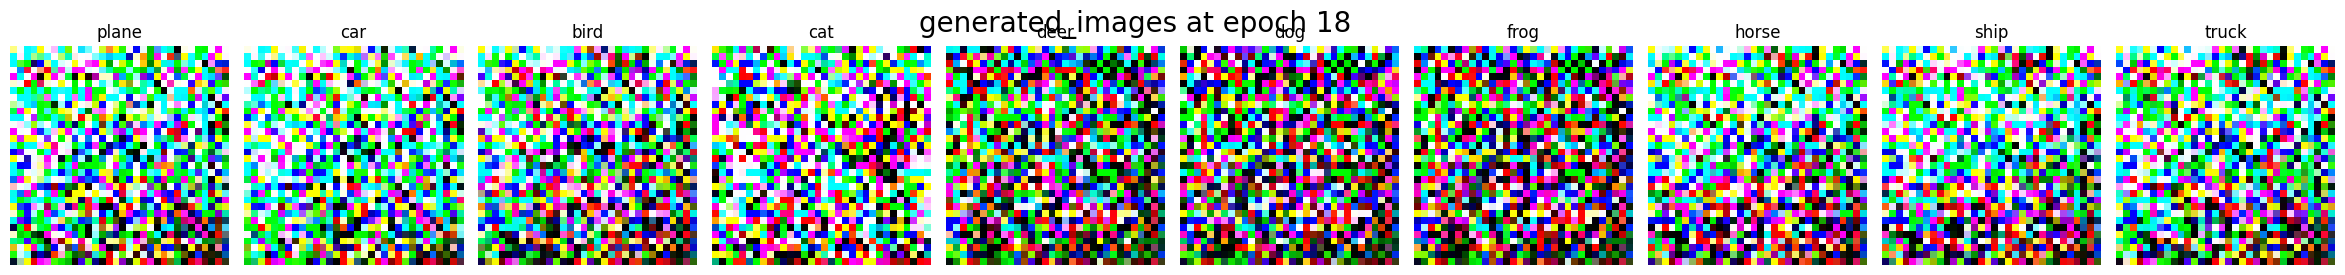

Epoch 19/60: : 100%|██████████| 1563/1563 [01:18<00:00, 19.92it/s, generator_loss=0.795, discriminator_loss=1.4, D(x)=0.445, D(G(z1))=0.447, D(G(z2))=0.447]


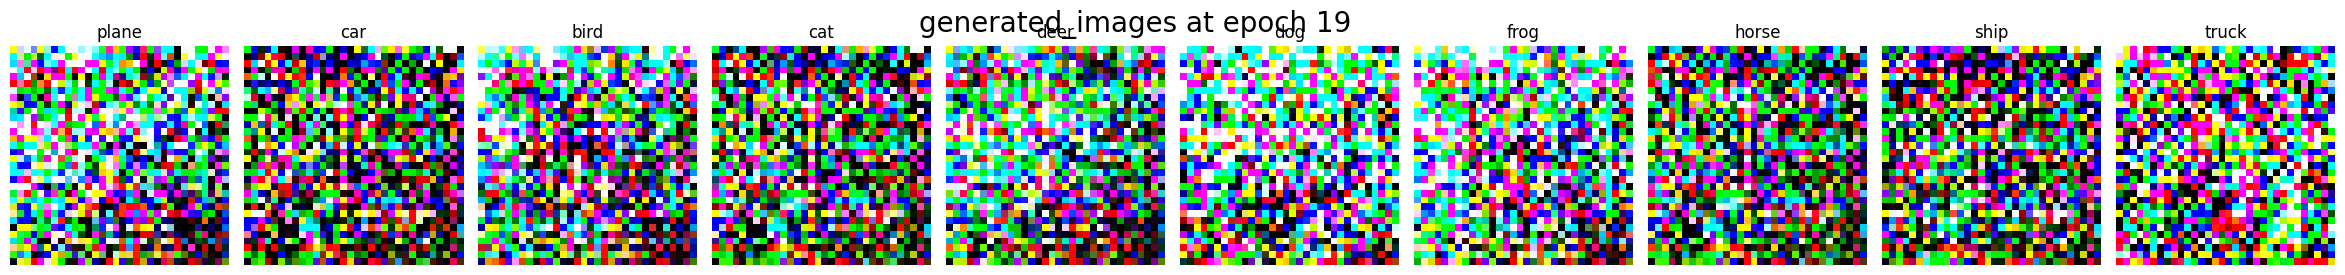

Epoch 20/60: : 100%|██████████| 1563/1563 [01:15<00:00, 20.65it/s, generator_loss=0.808, discriminator_loss=1.44, D(x)=0.447, D(G(z1))=0.443, D(G(z2))=0.443]


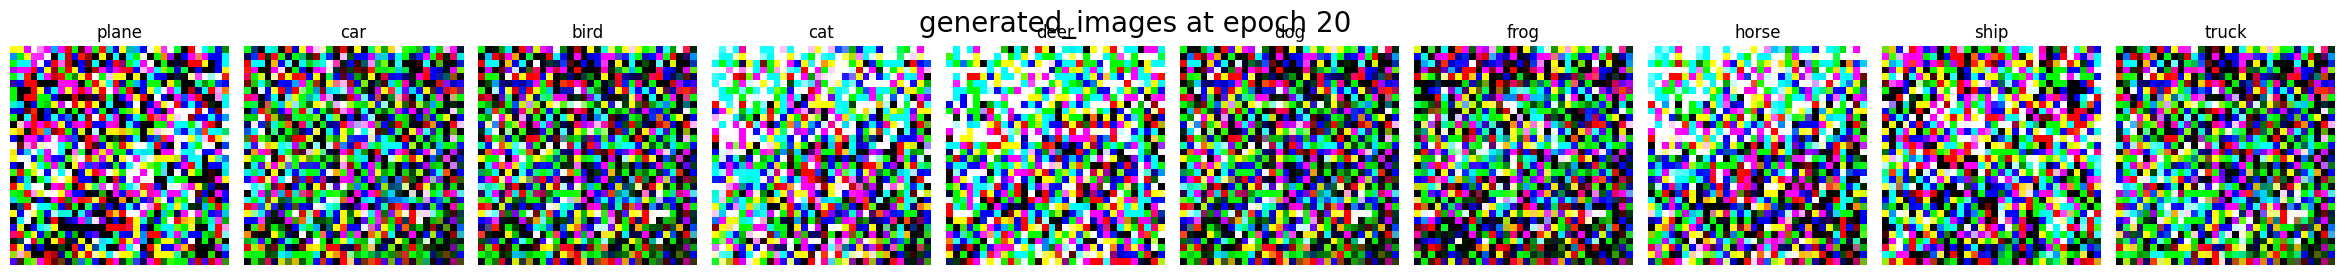

Epoch 21/60: : 100%|██████████| 1563/1563 [01:14<00:00, 20.93it/s, generator_loss=0.827, discriminator_loss=1.35, D(x)=0.451, D(G(z1))=0.433, D(G(z2))=0.433]


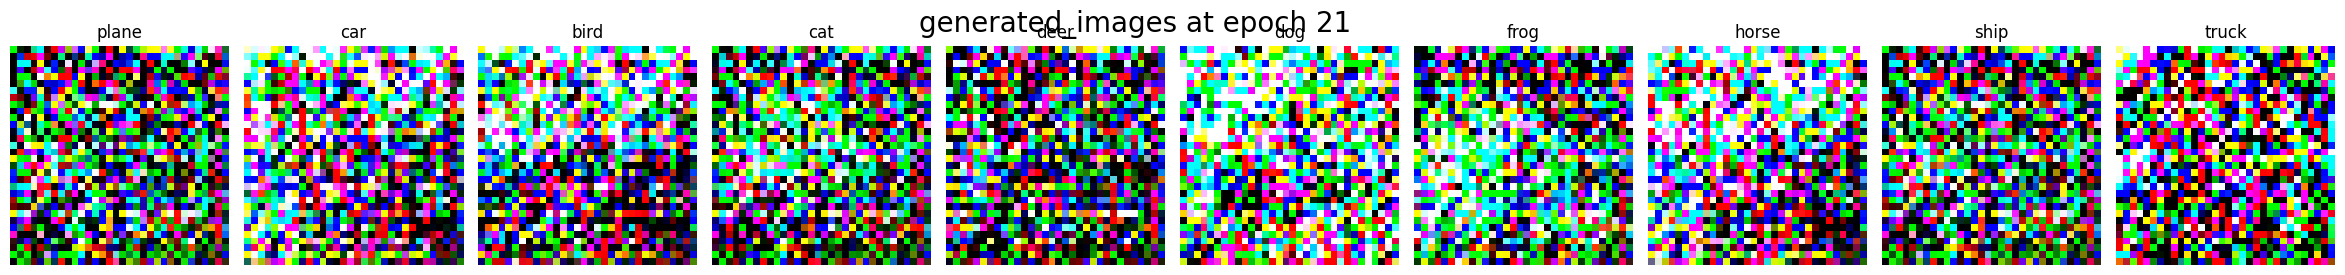

Epoch 22/60: : 100%|██████████| 1563/1563 [01:15<00:00, 20.61it/s, generator_loss=0.823, discriminator_loss=1.36, D(x)=0.444, D(G(z1))=0.438, D(G(z2))=0.438]


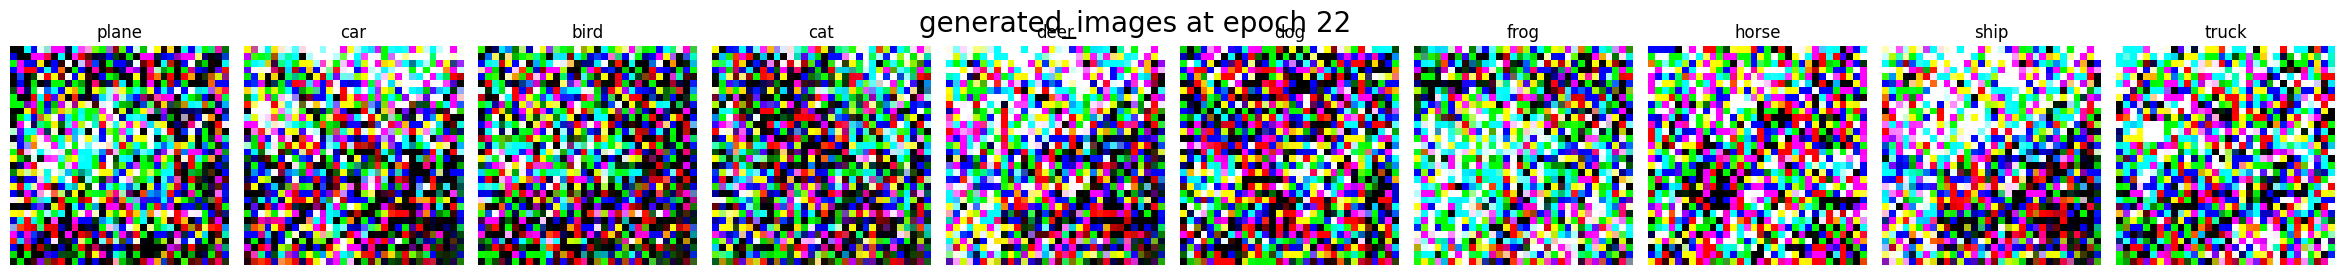

Epoch 23/60: : 100%|██████████| 1563/1563 [01:15<00:00, 20.72it/s, generator_loss=0.814, discriminator_loss=1.36, D(x)=0.462, D(G(z1))=0.431, D(G(z2))=0.431]


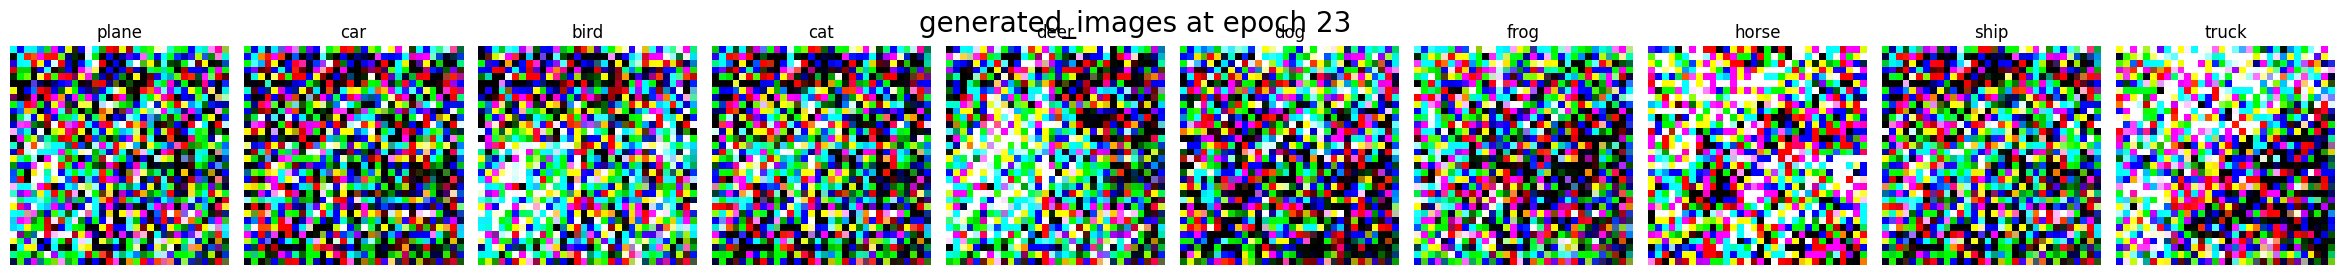

Epoch 24/60: : 100%|██████████| 1563/1563 [01:11<00:00, 21.95it/s, generator_loss=0.821, discriminator_loss=1.35, D(x)=0.458, D(G(z1))=0.439, D(G(z2))=0.439]


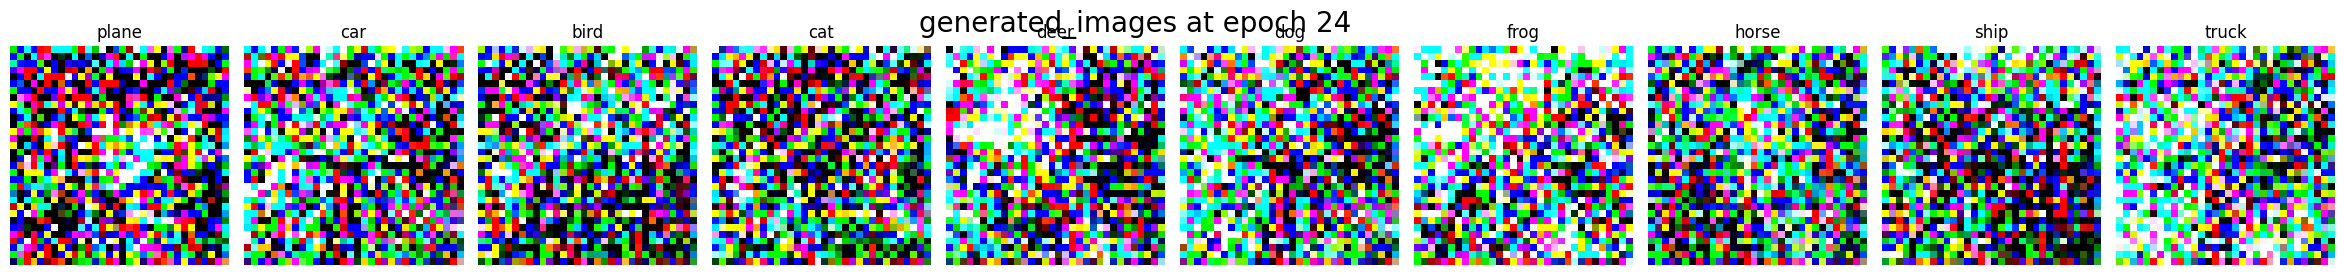

Epoch 25/60: : 100%|██████████| 1563/1563 [01:16<00:00, 20.33it/s, generator_loss=0.826, discriminator_loss=1.36, D(x)=0.471, D(G(z1))=0.435, D(G(z2))=0.435]


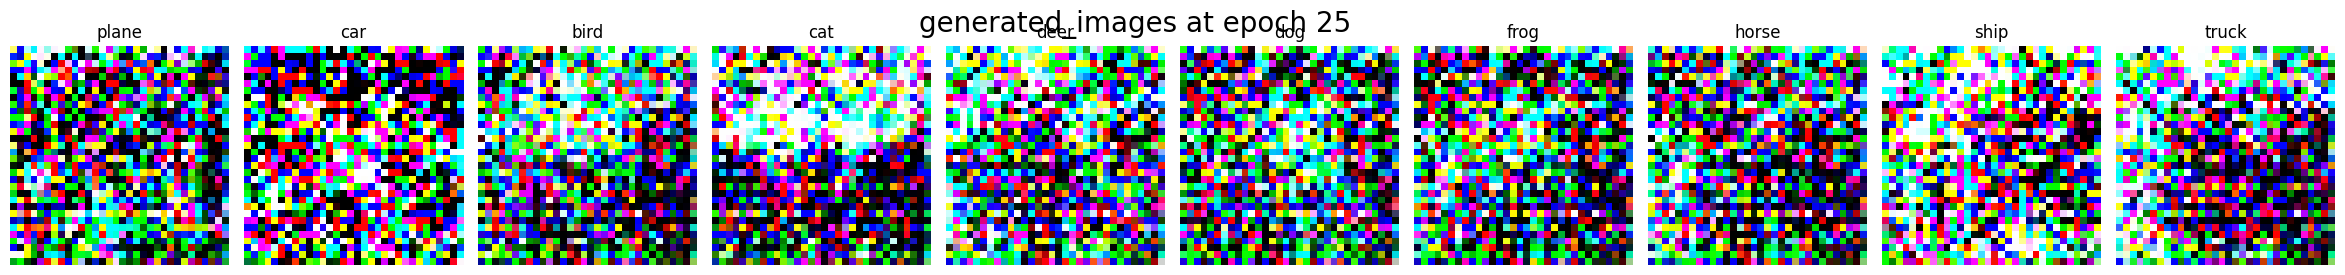

Epoch 26/60: : 100%|██████████| 1563/1563 [01:15<00:00, 20.72it/s, generator_loss=0.796, discriminator_loss=1.34, D(x)=0.474, D(G(z1))=0.428, D(G(z2))=0.428]


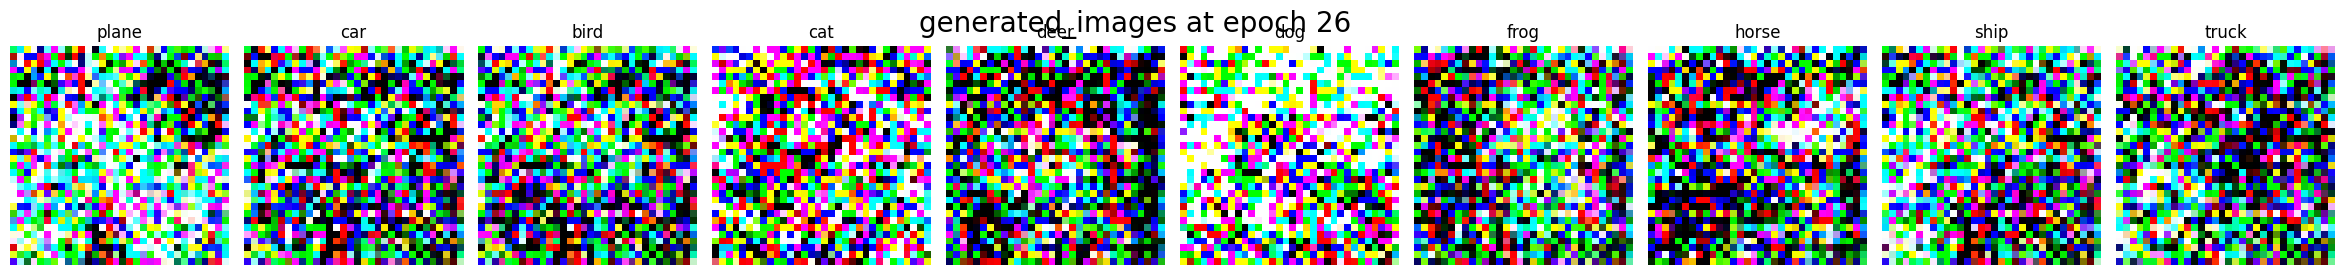

Epoch 27/60: : 100%|██████████| 1563/1563 [01:13<00:00, 21.20it/s, generator_loss=0.829, discriminator_loss=1.33, D(x)=0.464, D(G(z1))=0.428, D(G(z2))=0.428]


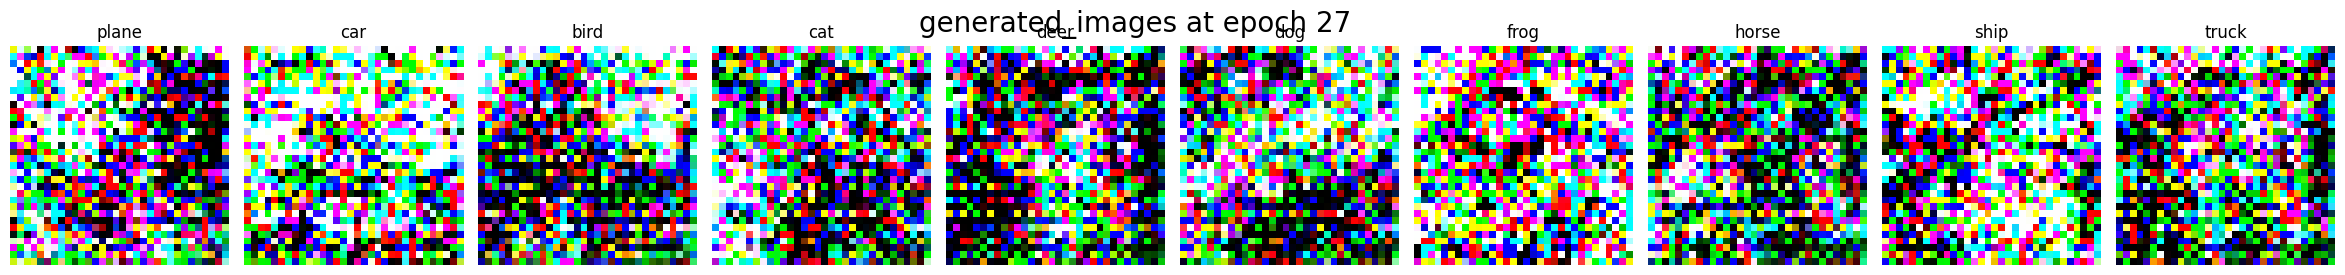

Epoch 28/60: : 100%|██████████| 1563/1563 [01:15<00:00, 20.74it/s, generator_loss=0.803, discriminator_loss=1.35, D(x)=0.48, D(G(z1))=0.419, D(G(z2))=0.419]


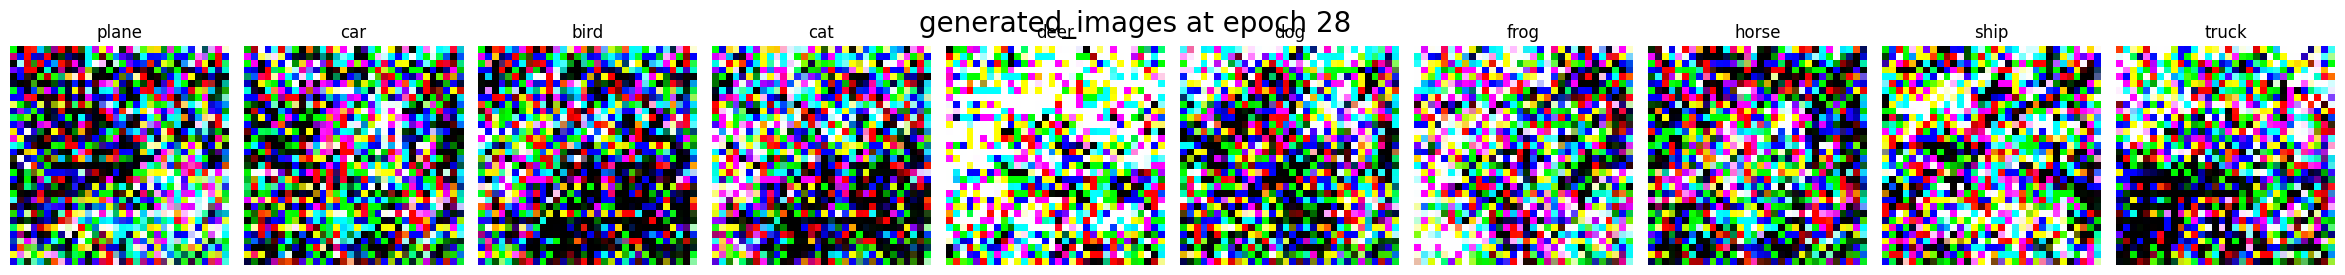

Epoch 29/60: : 100%|██████████| 1563/1563 [01:15<00:00, 20.59it/s, generator_loss=0.817, discriminator_loss=1.43, D(x)=0.44, D(G(z1))=0.436, D(G(z2))=0.436]


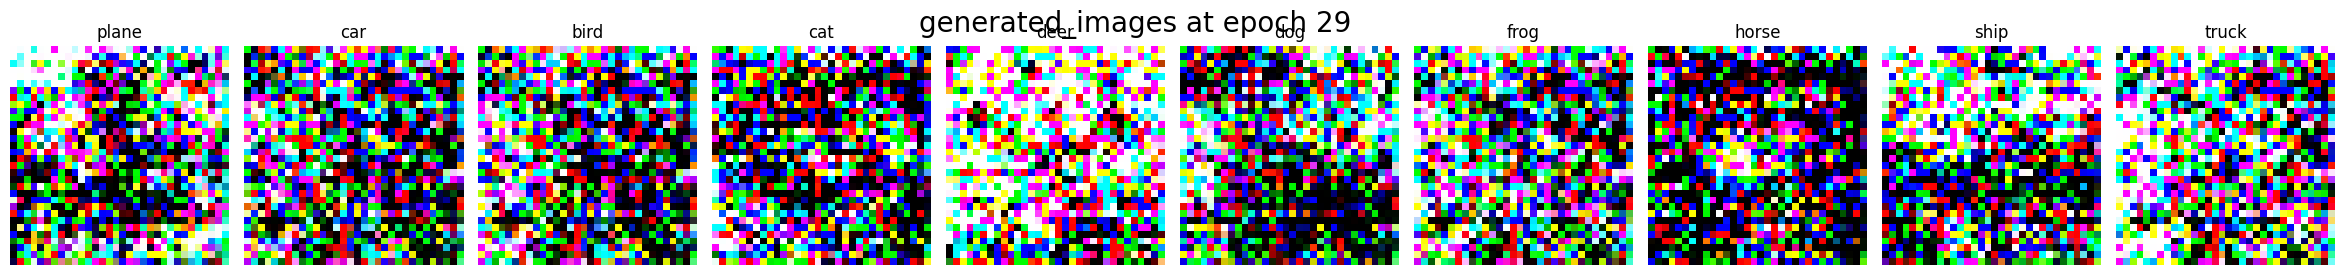

Epoch 30/60: : 100%|██████████| 1563/1563 [01:17<00:00, 20.18it/s, generator_loss=0.797, discriminator_loss=1.34, D(x)=0.48, D(G(z1))=0.421, D(G(z2))=0.421]


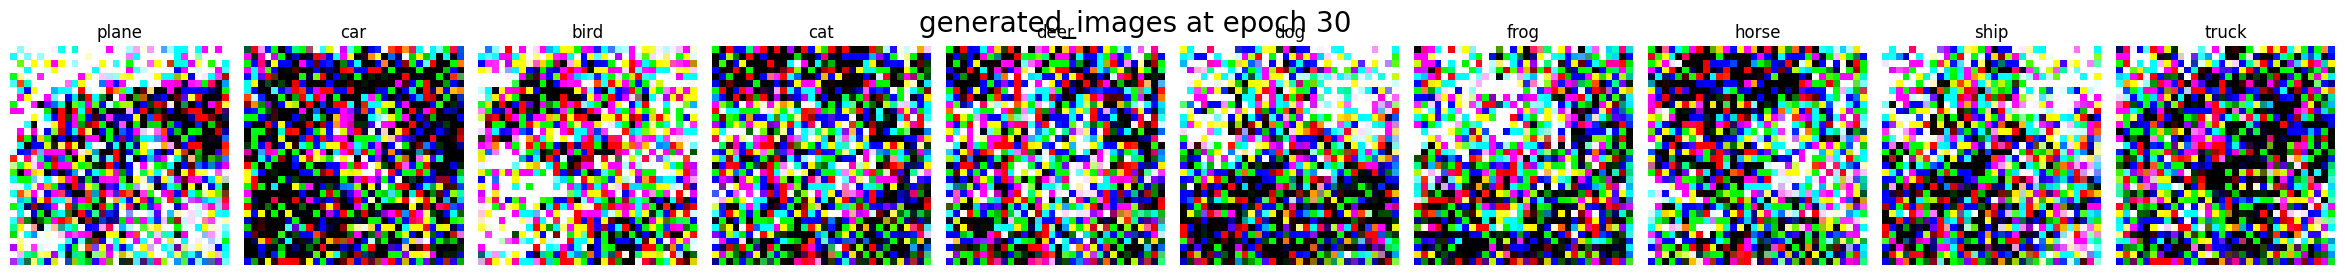

Epoch 31/60: : 100%|██████████| 1563/1563 [01:12<00:00, 21.51it/s, generator_loss=0.864, discriminator_loss=1.28, D(x)=0.478, D(G(z1))=0.416, D(G(z2))=0.416]


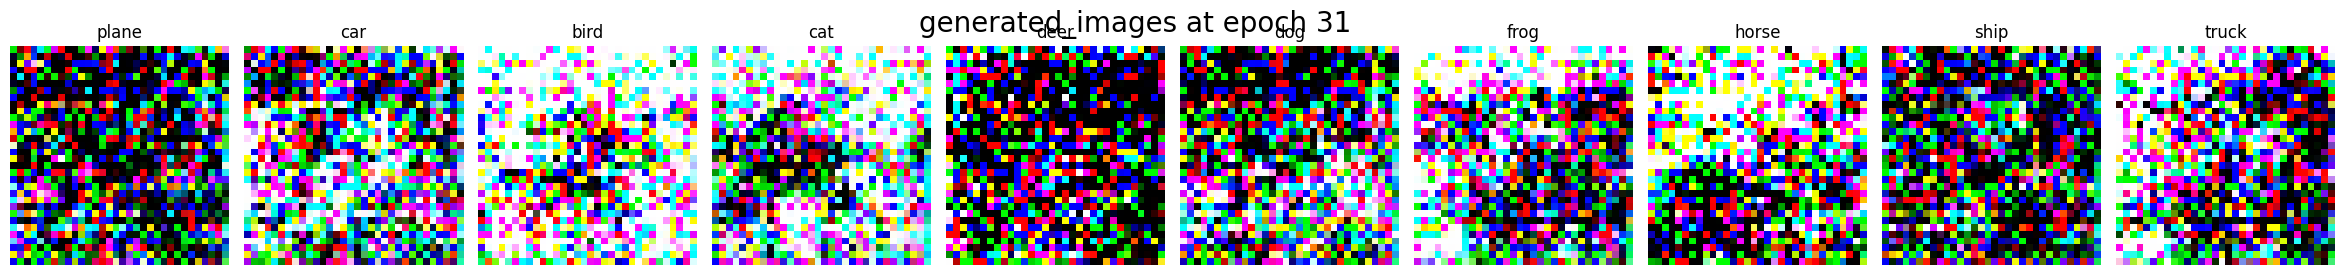

Epoch 32/60: : 100%|██████████| 1563/1563 [01:13<00:00, 21.19it/s, generator_loss=0.829, discriminator_loss=1.29, D(x)=0.475, D(G(z1))=0.424, D(G(z2))=0.424]


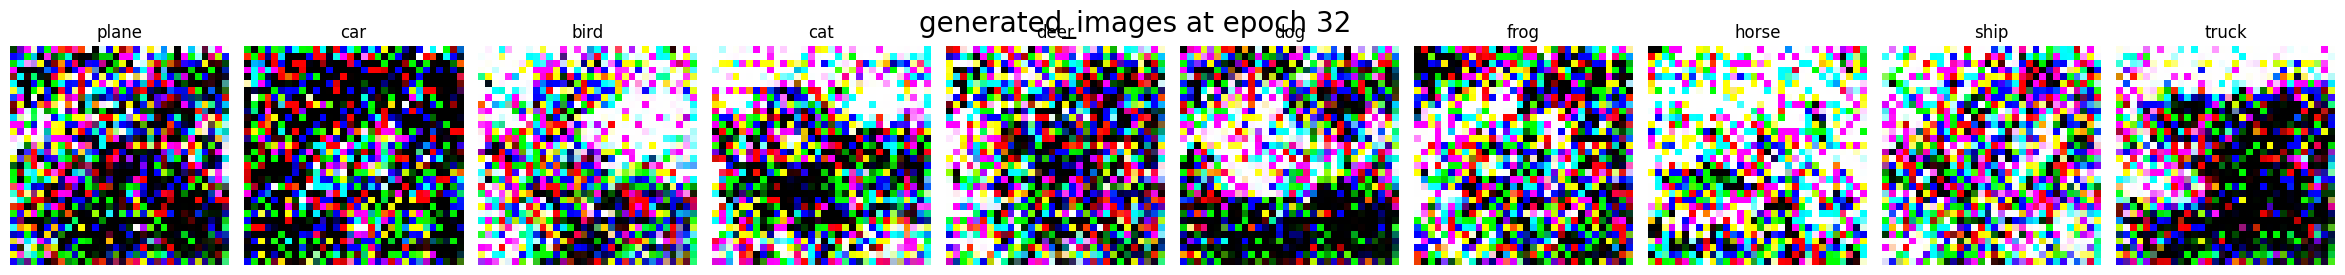

Epoch 33/60: : 100%|██████████| 1563/1563 [01:17<00:00, 20.16it/s, generator_loss=0.833, discriminator_loss=1.35, D(x)=0.465, D(G(z1))=0.419, D(G(z2))=0.419]


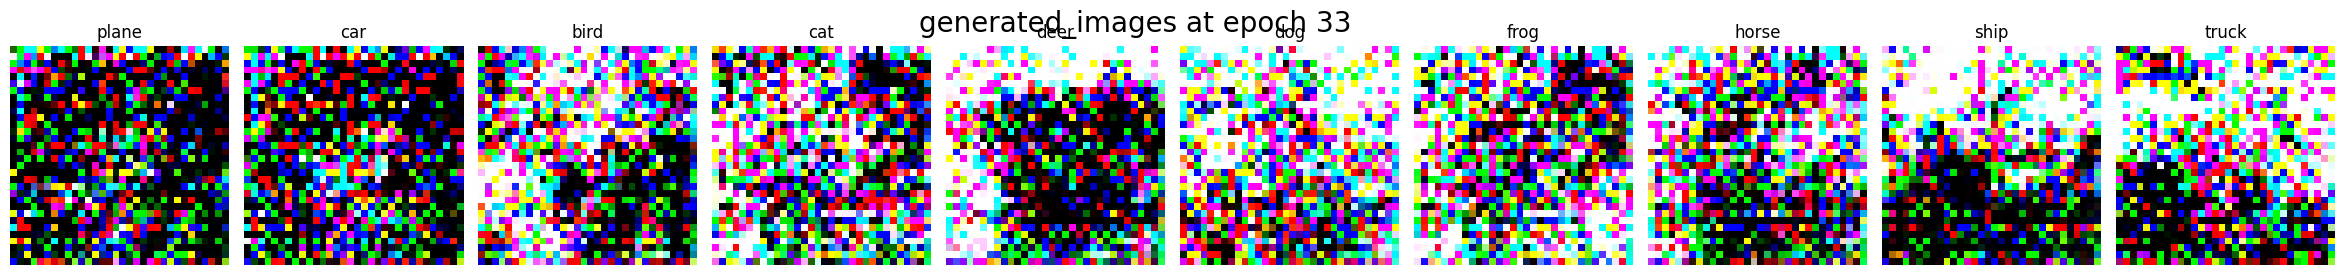

Epoch 34/60: : 100%|██████████| 1563/1563 [01:13<00:00, 21.17it/s, generator_loss=0.811, discriminator_loss=1.34, D(x)=0.48, D(G(z1))=0.418, D(G(z2))=0.418]


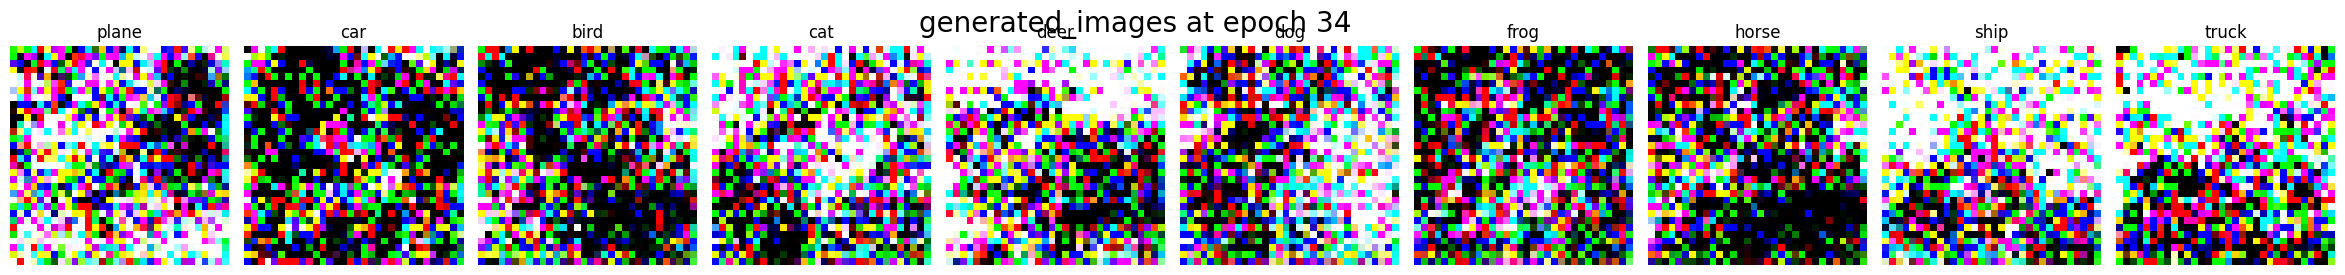

Epoch 35/60: : 100%|██████████| 1563/1563 [01:14<00:00, 21.09it/s, generator_loss=0.803, discriminator_loss=1.36, D(x)=0.453, D(G(z1))=0.419, D(G(z2))=0.419]


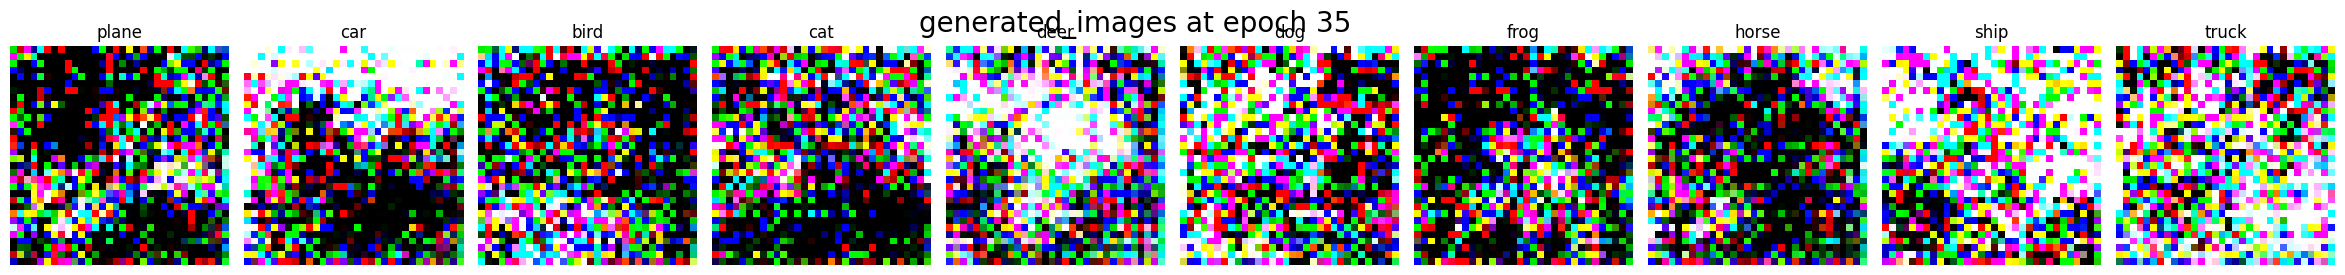

Epoch 36/60: : 100%|██████████| 1563/1563 [01:13<00:00, 21.16it/s, generator_loss=0.853, discriminator_loss=1.3, D(x)=0.495, D(G(z1))=0.413, D(G(z2))=0.413]


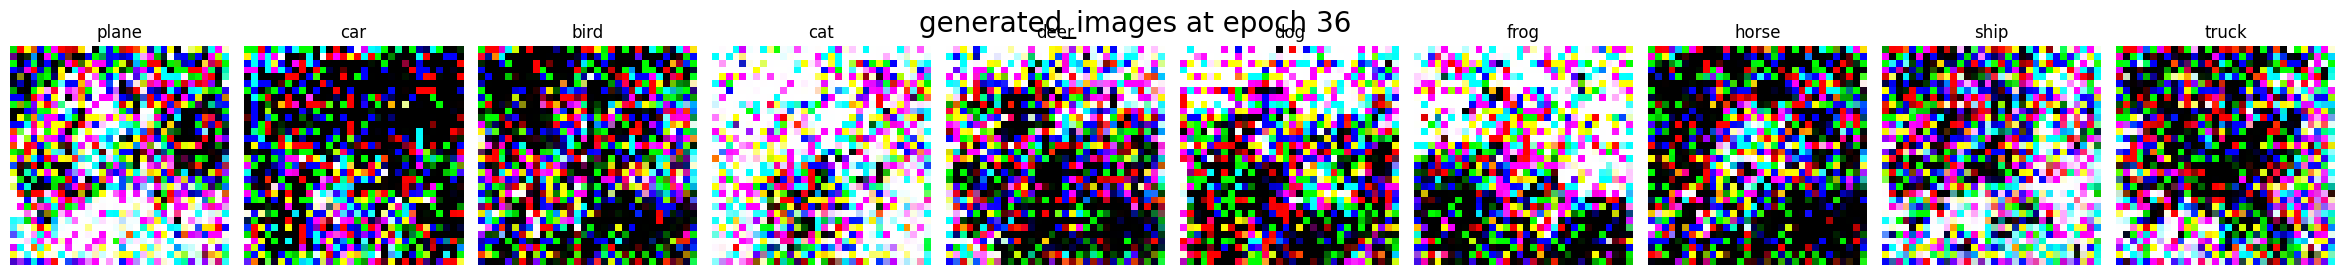

Epoch 37/60: : 100%|██████████| 1563/1563 [01:15<00:00, 20.59it/s, generator_loss=0.839, discriminator_loss=1.35, D(x)=0.469, D(G(z1))=0.417, D(G(z2))=0.417]


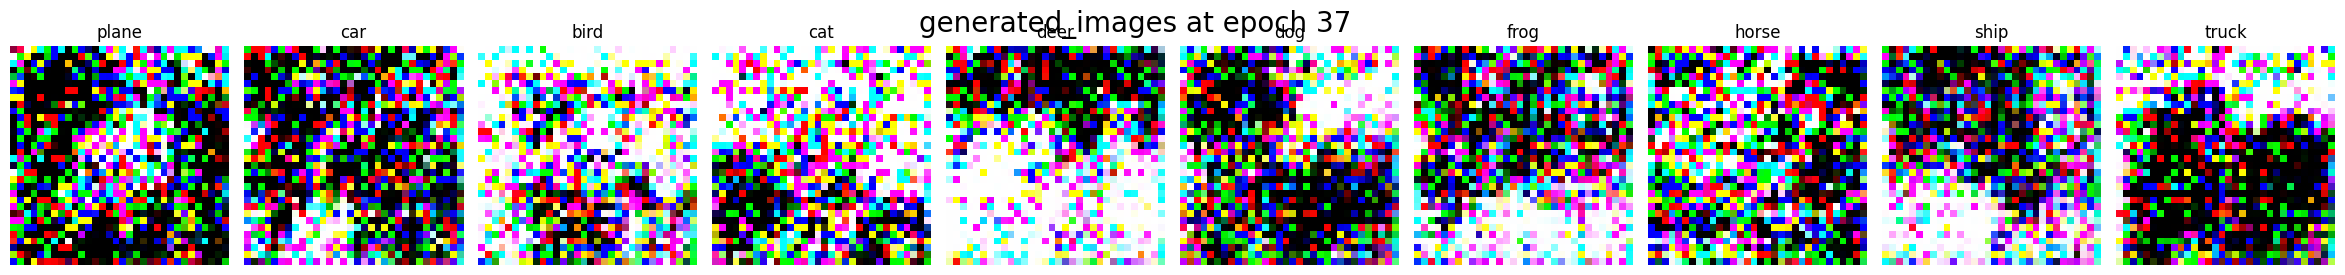

Epoch 38/60: : 100%|██████████| 1563/1563 [01:14<00:00, 20.90it/s, generator_loss=0.867, discriminator_loss=1.37, D(x)=0.457, D(G(z1))=0.415, D(G(z2))=0.414]


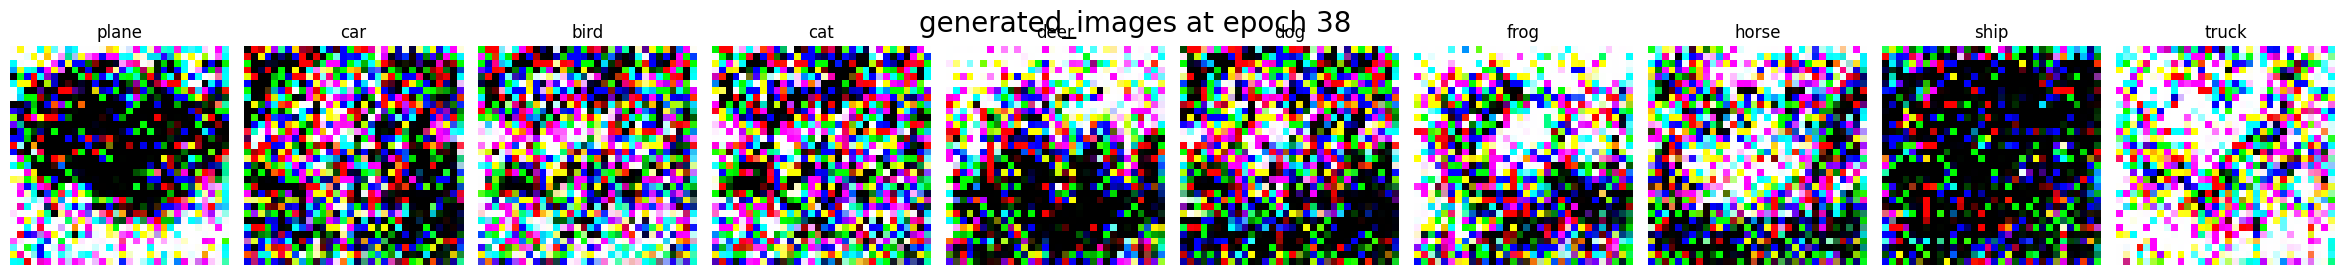

Epoch 39/60: : 100%|██████████| 1563/1563 [01:10<00:00, 22.25it/s, generator_loss=0.814, discriminator_loss=1.31, D(x)=0.469, D(G(z1))=0.414, D(G(z2))=0.414]


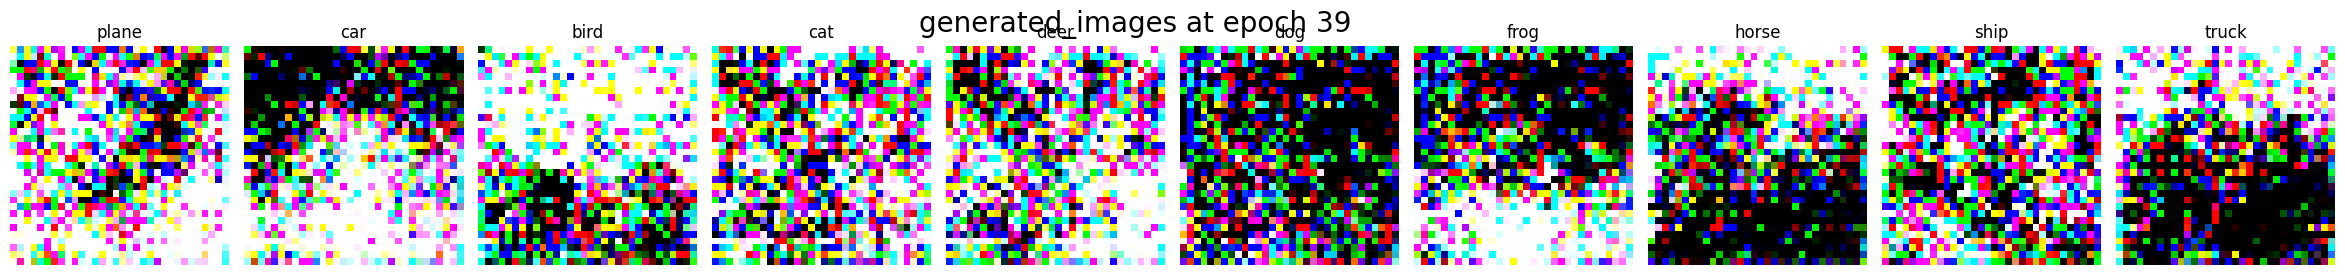

Epoch 40/60: : 100%|██████████| 1563/1563 [01:08<00:00, 22.86it/s, generator_loss=0.81, discriminator_loss=1.29, D(x)=0.489, D(G(z1))=0.413, D(G(z2))=0.413]


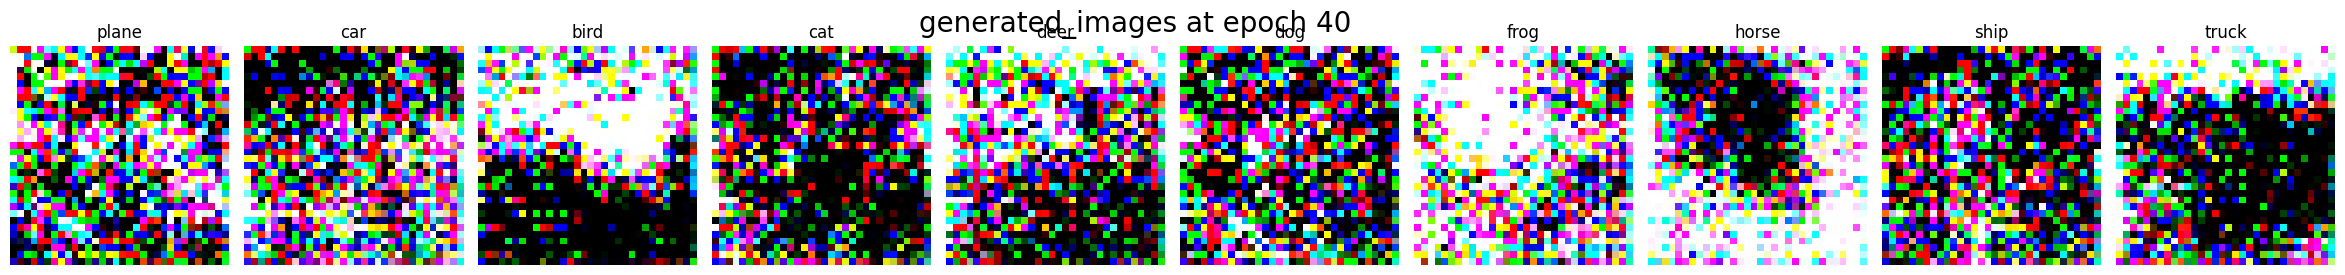

Epoch 41/60: : 100%|██████████| 1563/1563 [01:13<00:00, 21.13it/s, generator_loss=0.873, discriminator_loss=1.23, D(x)=0.494, D(G(z1))=0.404, D(G(z2))=0.404]


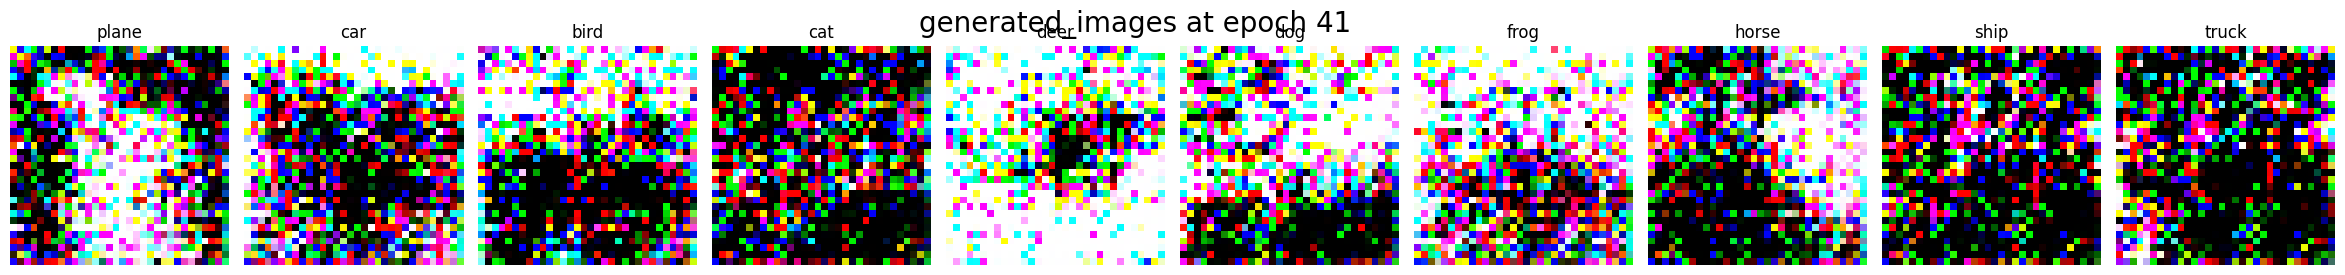

Epoch 42/60: : 100%|██████████| 1563/1563 [01:17<00:00, 20.12it/s, generator_loss=0.899, discriminator_loss=1.27, D(x)=0.486, D(G(z1))=0.408, D(G(z2))=0.408]


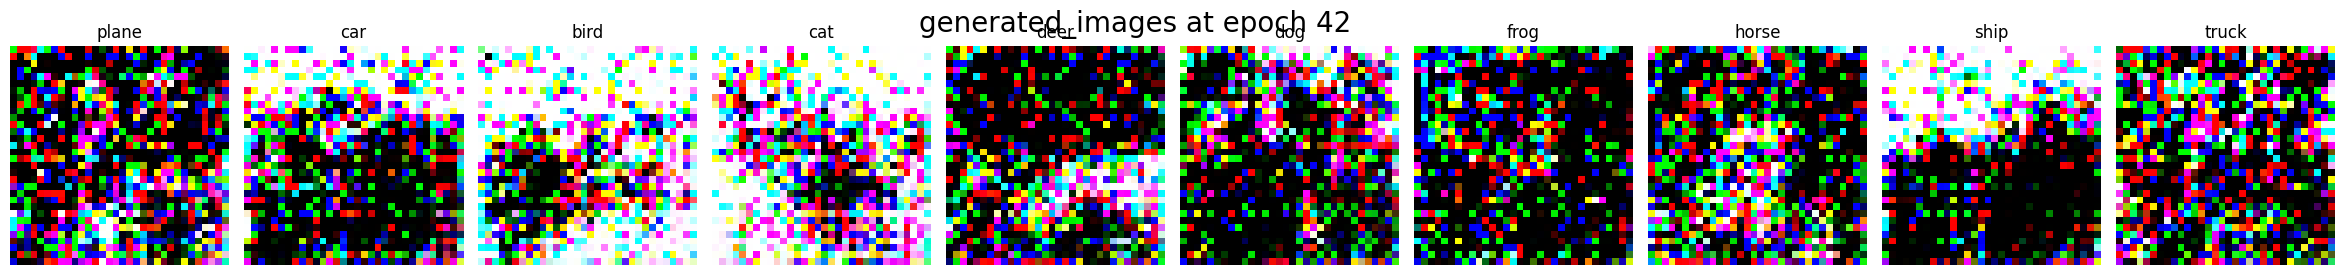

Epoch 43/60: : 100%|██████████| 1563/1563 [01:16<00:00, 20.38it/s, generator_loss=0.84, discriminator_loss=1.35, D(x)=0.47, D(G(z1))=0.411, D(G(z2))=0.411]


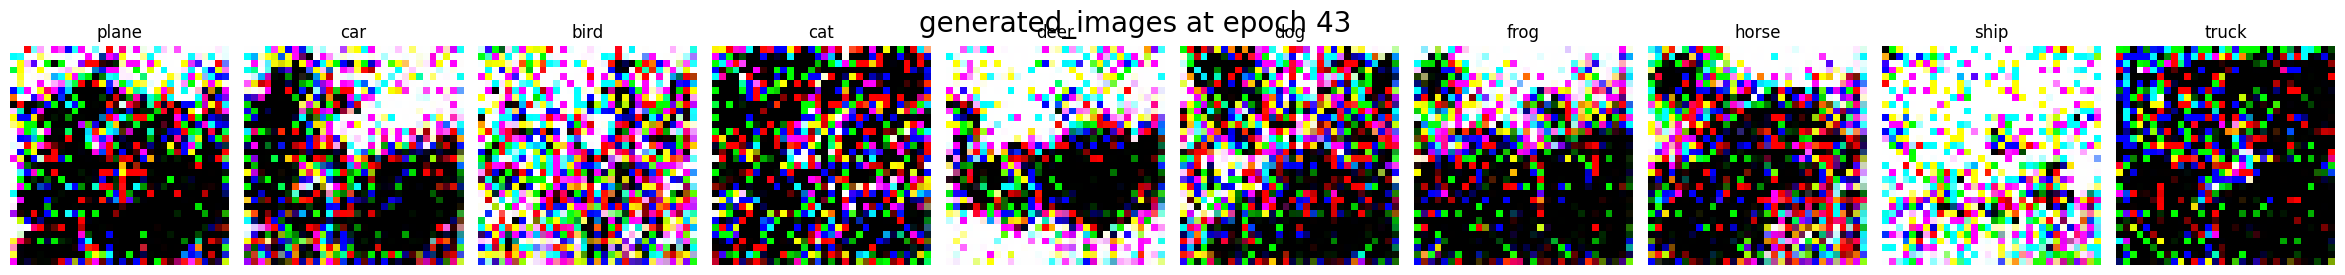

Epoch 44/60: : 100%|██████████| 1563/1563 [01:18<00:00, 19.80it/s, generator_loss=0.814, discriminator_loss=1.28, D(x)=0.502, D(G(z1))=0.402, D(G(z2))=0.402]


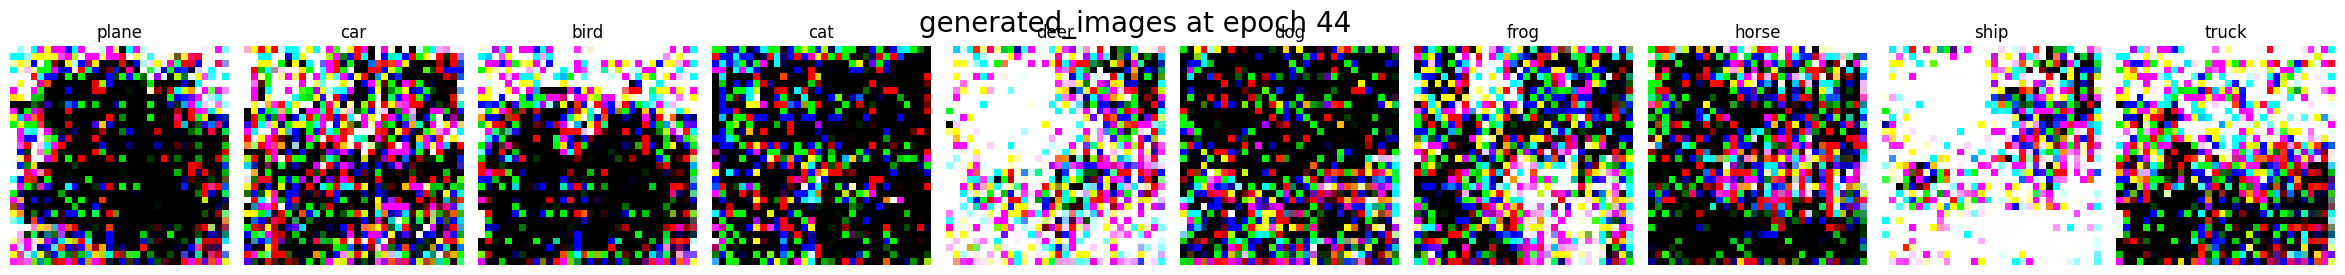

Epoch 45/60: : 100%|██████████| 1563/1563 [01:18<00:00, 19.90it/s, generator_loss=0.873, discriminator_loss=1.37, D(x)=0.455, D(G(z1))=0.409, D(G(z2))=0.409]


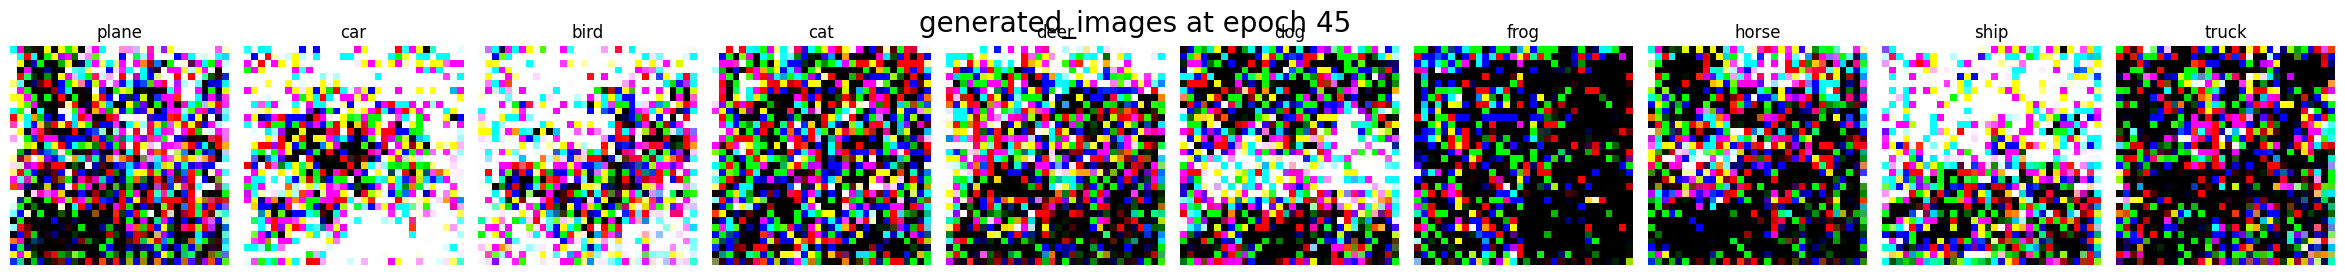

Epoch 46/60: : 100%|██████████| 1563/1563 [01:17<00:00, 20.25it/s, generator_loss=0.869, discriminator_loss=1.27, D(x)=0.497, D(G(z1))=0.401, D(G(z2))=0.401]


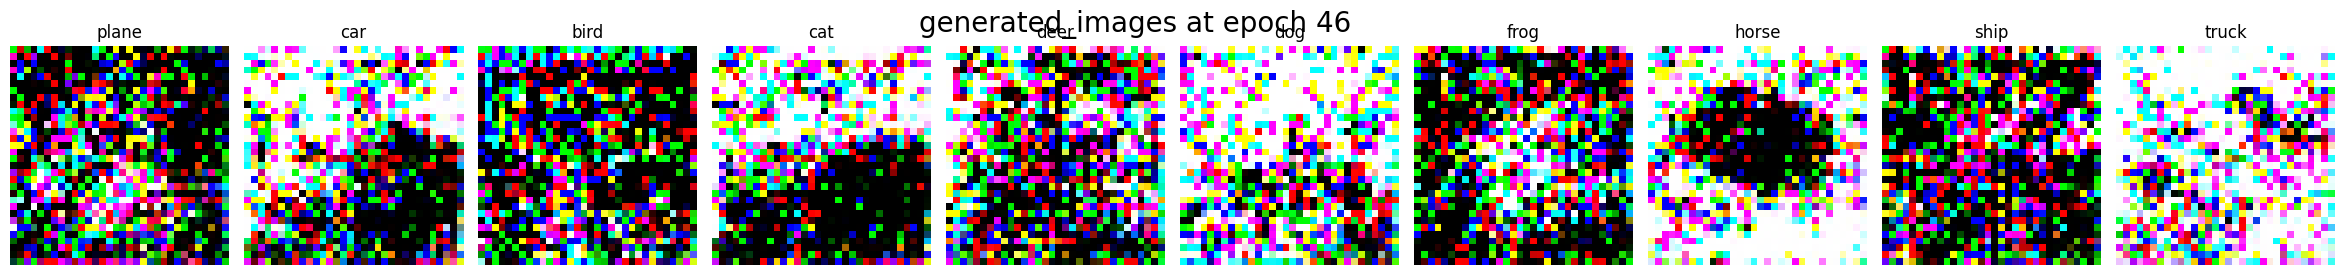

Epoch 47/60: : 100%|██████████| 1563/1563 [01:20<00:00, 19.45it/s, generator_loss=0.842, discriminator_loss=1.35, D(x)=0.464, D(G(z1))=0.407, D(G(z2))=0.407]


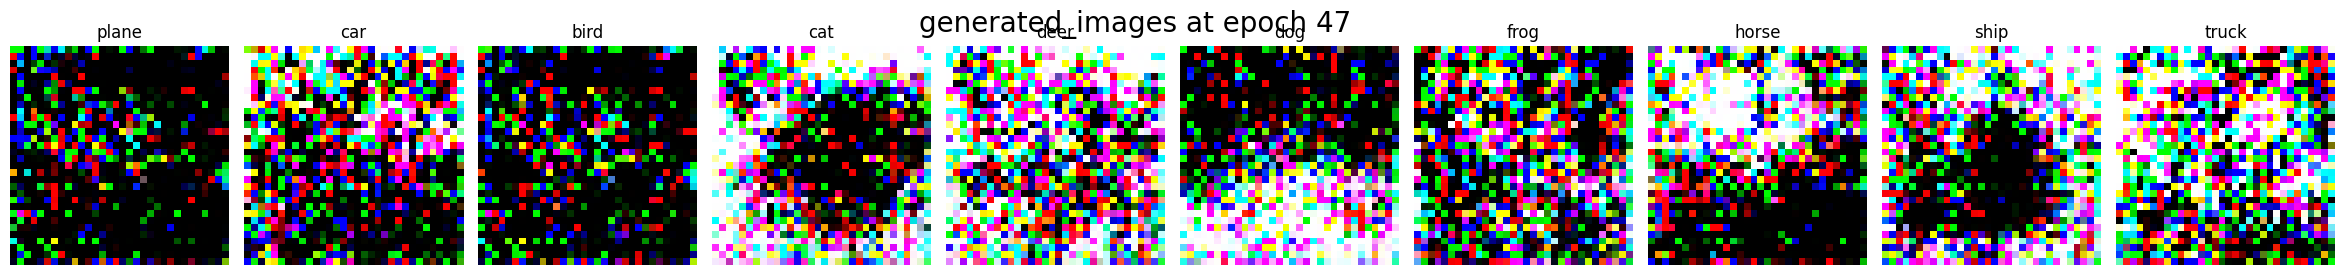

Epoch 48/60: : 100%|██████████| 1563/1563 [01:20<00:00, 19.39it/s, generator_loss=0.854, discriminator_loss=1.26, D(x)=0.491, D(G(z1))=0.4, D(G(z2))=0.4]


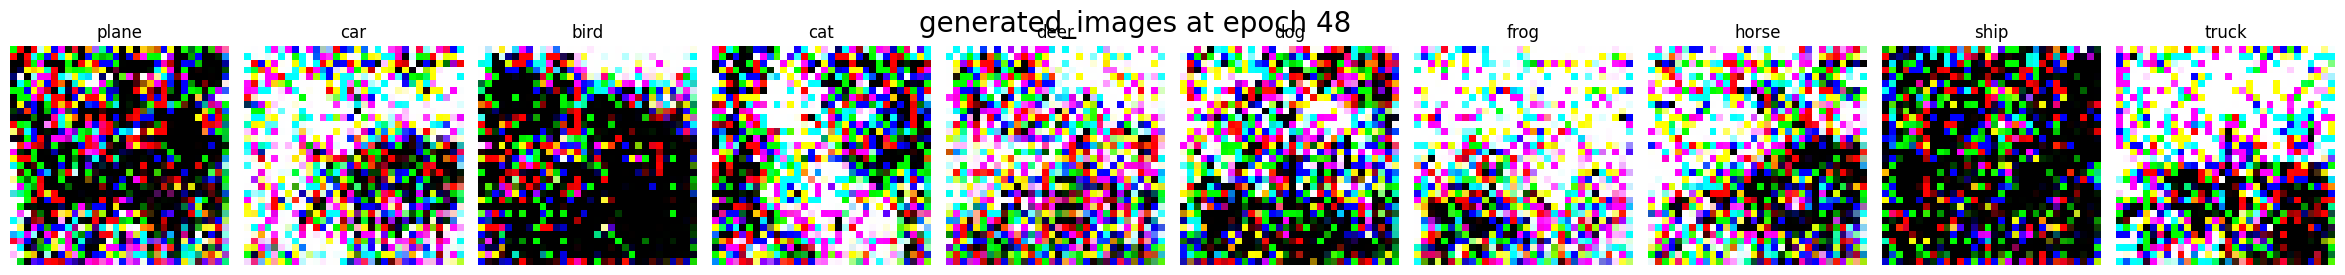

Epoch 49/60: : 100%|██████████| 1563/1563 [01:19<00:00, 19.57it/s, generator_loss=0.843, discriminator_loss=1.32, D(x)=0.485, D(G(z1))=0.4, D(G(z2))=0.4]


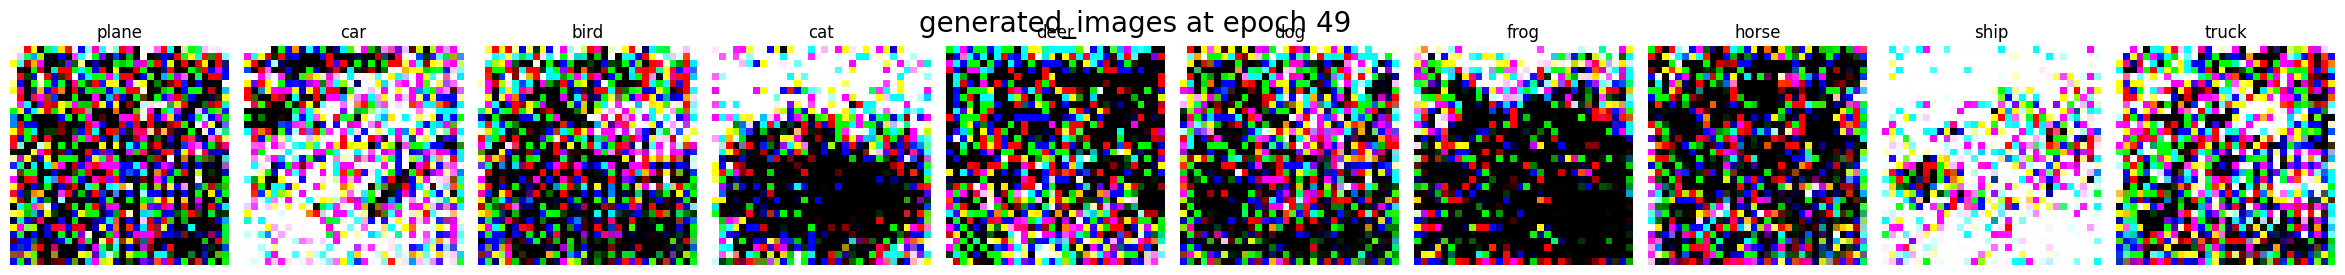

Epoch 50/60: : 100%|██████████| 1563/1563 [01:18<00:00, 19.88it/s, generator_loss=0.909, discriminator_loss=1.29, D(x)=0.498, D(G(z1))=0.395, D(G(z2))=0.395]


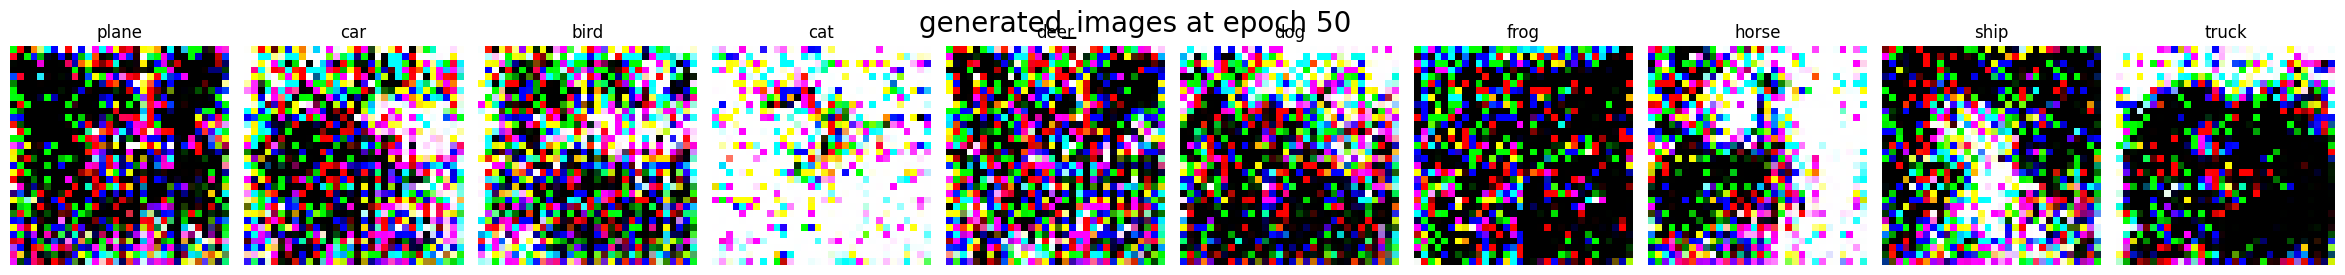

Epoch 51/60: : 100%|██████████| 1563/1563 [01:19<00:00, 19.77it/s, generator_loss=0.838, discriminator_loss=1.31, D(x)=0.474, D(G(z1))=0.411, D(G(z2))=0.411]


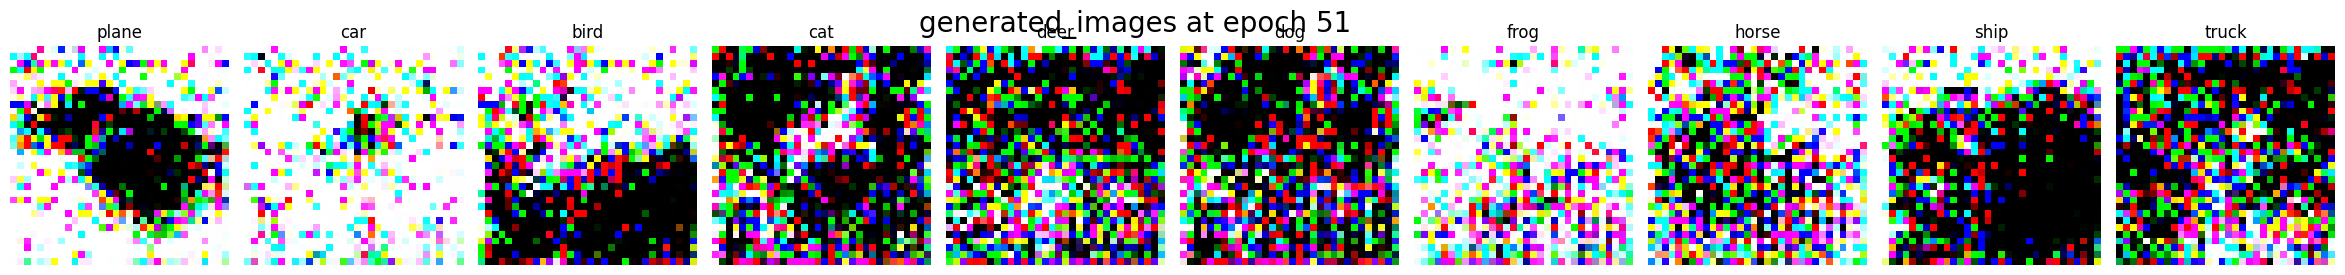

Epoch 52/60: : 100%|██████████| 1563/1563 [01:20<00:00, 19.30it/s, generator_loss=0.889, discriminator_loss=1.28, D(x)=0.508, D(G(z1))=0.392, D(G(z2))=0.392]


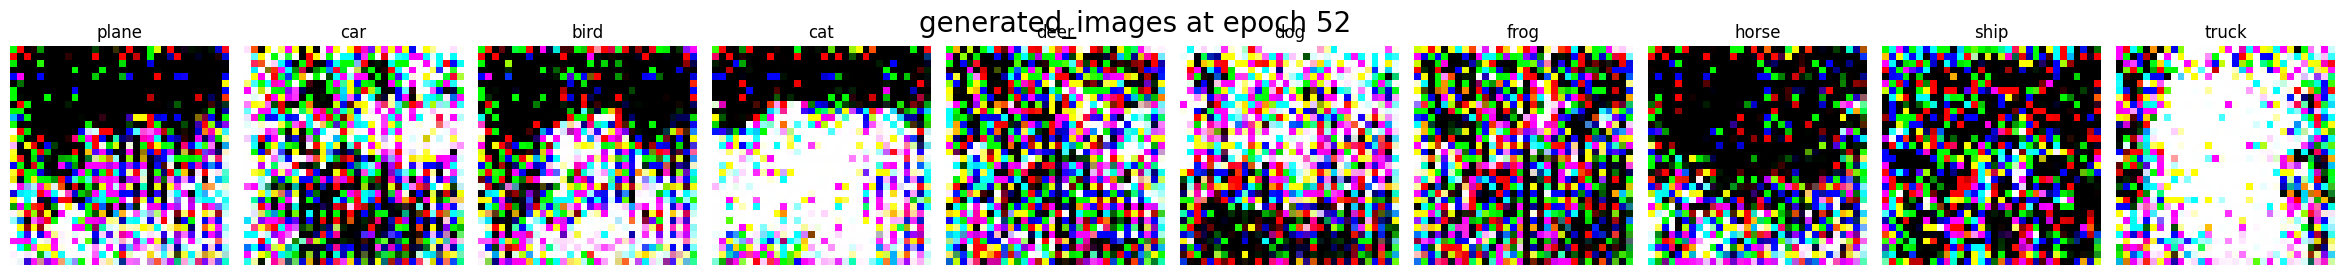

Epoch 53/60: : 100%|██████████| 1563/1563 [01:18<00:00, 19.98it/s, generator_loss=0.88, discriminator_loss=1.22, D(x)=0.495, D(G(z1))=0.395, D(G(z2))=0.395]


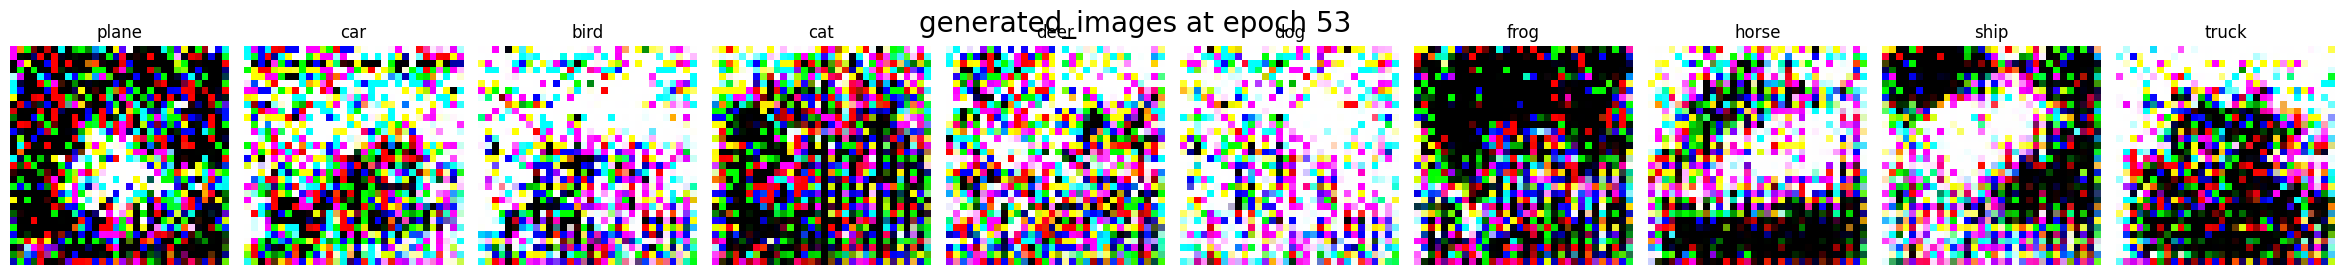

Epoch 54/60: : 100%|██████████| 1563/1563 [01:17<00:00, 20.23it/s, generator_loss=0.824, discriminator_loss=1.32, D(x)=0.483, D(G(z1))=0.41, D(G(z2))=0.41]


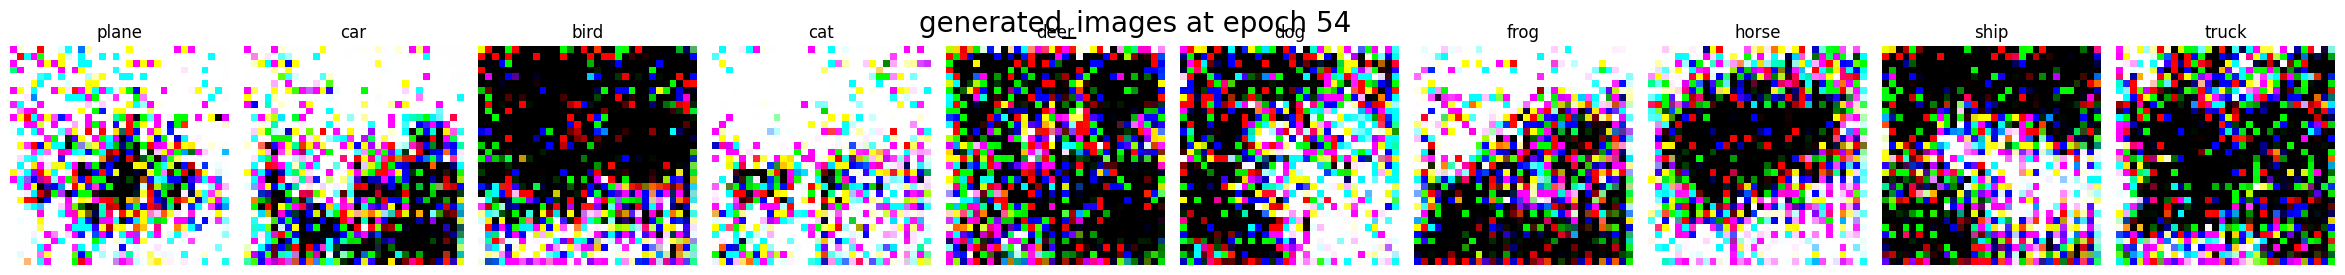

Epoch 55/60: : 100%|██████████| 1563/1563 [01:17<00:00, 20.04it/s, generator_loss=0.843, discriminator_loss=1.22, D(x)=0.506, D(G(z1))=0.39, D(G(z2))=0.39]


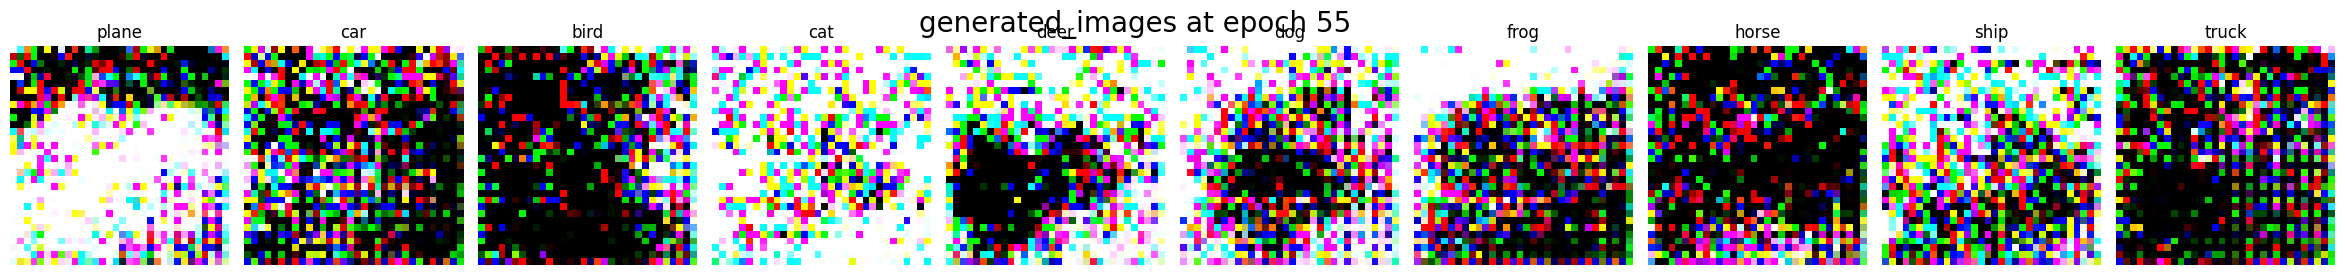

Epoch 56/60: :  66%|██████▌   | 1028/1563 [00:52<00:27, 19.59it/s, generator_loss=0.931, discriminator_loss=1.21, D(x)=0.513, D(G(z1))=0.391, D(G(z2))=0.391]

In [ ]:
real_label = 1
fake_label = 0
is_real = True
sample_labels = torch.arange(10).to(device)


discriminator.train()
generator.train()

# Training loop
for i in range(1,EPOCHS+1):
  pbar = tqdm(train_dataloader)
  for b, data in enumerate(pbar):

    inputs, _ = data                                                            # Every data instance is an input + label pair. We don't need the label
    inputs = (inputs - 0.5) * 2                                                 # setting data range to [-1,1]

    inputs_grayscale = torch.mean(inputs, dim=1, keepdim=True).to(device)       # Convert into grayscale images for the generator

    inputs = inputs.to(device)

                ###############################################################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))) #
                ###############################################################

    ## Train with all-real batch ##

    discriminator.zero_grad()
    is_real = True

    # Set up labels
    label = torch.full((inputs.shape[0],1), real_label,
                       dtype=torch.float, device=device)
    label = smooth_labels(label, is_real, smoothing_factor=0.25)                # smooth labels for discriminator with 25% variance
    label = noisy_labels(label, flip_ratio=0.01)                                # noisy labels for discriminator with 1% probability

    # Forward pass real batch through D
    output = discriminator(inputs, inputs_grayscale)

    # Calculate loss on all-real batch
    errD_real = loss_fn(output, label)

    # Calculate gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()

# --------------------------------------------------------------------------------------------

    ## Train with all-fake batch ##

    # Generate batch of latent (noise) vectors
    noise = 0.0005 * torch.randn(inputs.shape[0], 32, device=device)
    noise = noise_enr(noise)                                                    # Make noise shape image-like
    is_real = False
    label = torch.full((inputs.shape[0],1), fake_label, dtype=torch.float, device=device)
    label = smooth_labels(label, is_real, smoothing_factor=0.25)                # smooth labels for discriminator with 25% variance

    # Generate fake image batch with G
    fake = generator(noise, inputs_grayscale)

    # Classify all fake batch with D
    output = discriminator(fake.detach(), inputs_grayscale)

    # Calculate D's loss on the all-fake batch
    errD_fake = loss_fn(output, label)

    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    D_G_z1 = output.mean().item()

    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake

    # Update D
    optimizer_disc.step()

# --------------------------------------------------------------------------------------------

                ###############################################################
                ######### (2) Update G network: maximize log(D(G(z))) #########
                ###############################################################

    generator.zero_grad()
    is_real = True
    label.fill_(real_label)                                                     # fake labels are real for generator cost
    label = torch.full((inputs.shape[0],1), real_label,
                       dtype=torch.float, device=device)
    label = smooth_labels(label, is_real, smoothing_factor=0.25)
    label = noisy_labels(label, flip_ratio=0.001)

    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = discriminator(fake, inputs_grayscale)

    # Calculate G's loss based on this output
    errG = loss_fn(output, label)

    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()

    # Update G
    optimizer_gen.step()

    pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
    pbar.set_postfix({"generator_loss": errG.item(), "discriminator_loss": errD.item(), "D(x)": D_x, "D(G(z1))": D_G_z1, "D(G(z2))": D_G_z2})

  with torch.no_grad():
    generations = generator(noise, inputs_grayscale).cpu()
    generations = (generations + 1) / 2 # setting generations range to [0,1]
  display_image_grid(generations.squeeze(1), sample_labels, 1, 10, f"generated_images at epoch {i}")


# AutoEncoder

## Import Relevant Libraries

In [ ]:
from torchvision.datasets import CIFAR10
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms


## Hyperparameters

In [ ]:
EPOCHS = 10
LEARNING_RATE = 1e-4
BATCH_SIZE = 64

## Download and Prepare data

### weighted grayscaling

In [ ]:
train_data = CIFAR10(root='./datasets', train=True, download=True, transform=transforms.ToTensor())
test_data = CIFAR10(root='./datasets', train=True, download=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_data,batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data,batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


Files already downloaded and verified


## Define Model Class

# Increase the nunmber of inside channels
# increase the kernel size

In [ ]:
import torch
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(                                           # Input:  N, 1, 32, 32
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),               # Output: N, 32, 32, 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),                              # Output: N, 32, 16, 16
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),              # Output: N, 64, 16, 16
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)                               # Output: N, 64, 8, 8
        )

        self.decoder = nn.Sequential(                                           # Input:  N, 64, 8, 8
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # Output: N, 32, 16, 16
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),      # Output: N, 3, 32, 32
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        xhat = self.decoder(z)
        return xhat


## Commence Training Loop

Epoch 9/10: : 100%|██████████| 782/782 [00:15<00:00, 50.06it/s, loss=0.00614]


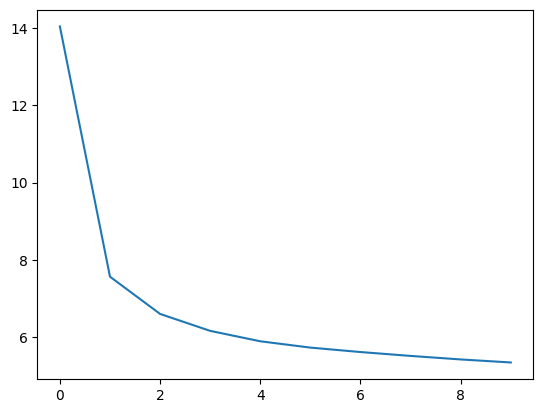

In [ ]:
device = torch.device("cuda:0")
auto_encoder = AE().to(device)
opt = optim.Adam(auto_encoder.parameters(), lr = LEARNING_RATE)

ls = []
for i in range(EPOCHS):
  total_loss = 0
  pbar = tqdm(train_loader)
  for j,batch in enumerate(pbar):

    # Prepare normal and grayscaled images
    img = batch[0].to(device)
    img_gray = torch.mean(img, dim = 1, keepdim = True)

    # Make the model prediction for the colored image
    img_predicted = auto_encoder(img_gray)

    # Measure the loss and optimize the model
    loss = F.mse_loss(img_predicted, img)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()
    pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
    pbar.set_postfix({"loss": loss.item()})

  ls.append(total_loss)

plt.plot(ls)

## Infer Results

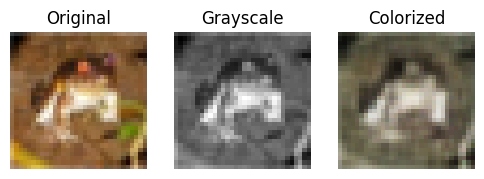

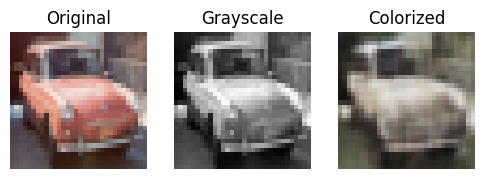

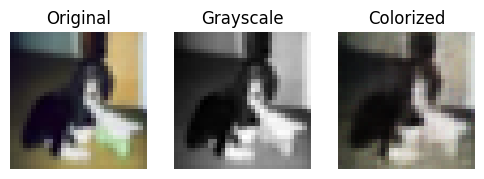

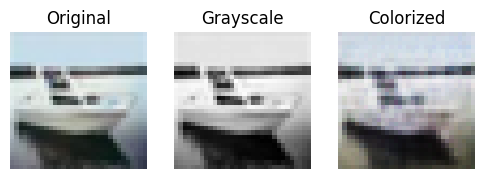

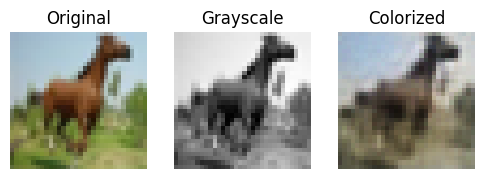

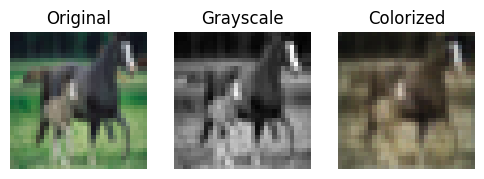

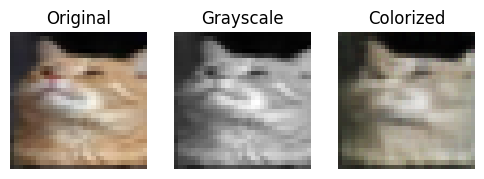

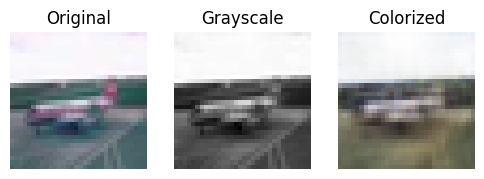

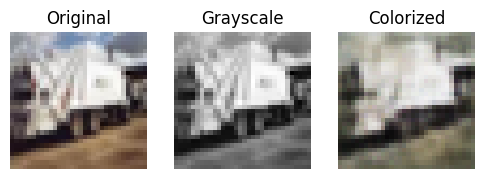

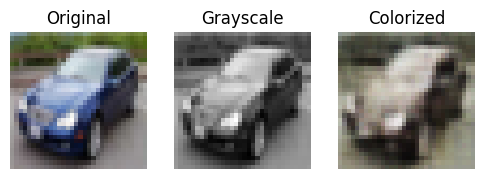

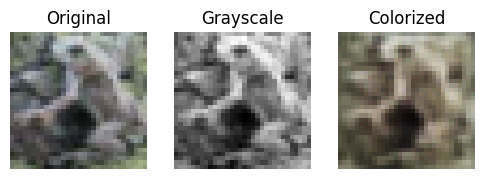

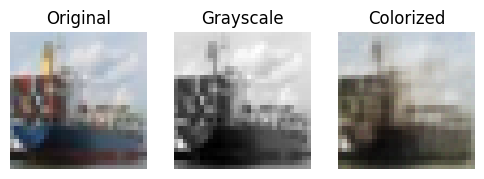

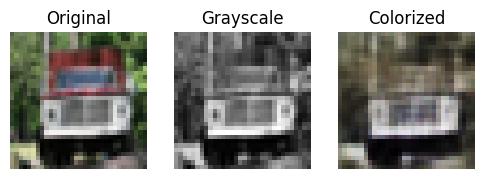

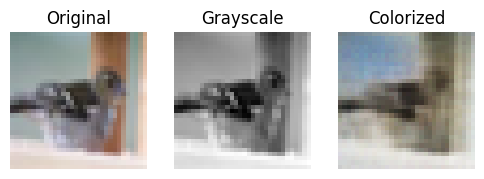

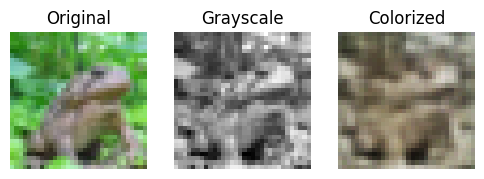

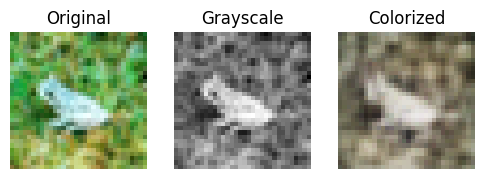

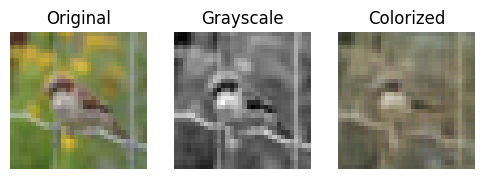

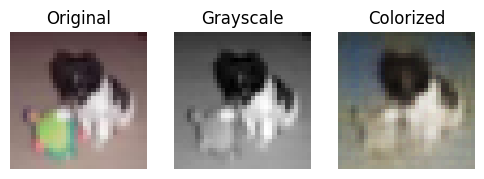

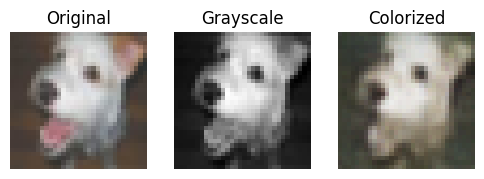

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

auto_encoder.eval()  # Set the model to evaluation mode
test_loss = 0

with torch.no_grad():
    for c, batch in enumerate(test_loader):
        if c == 19:
          break

        img = batch[0].to(device)
        img_gray = torch.mean(img, dim = 1, keepdim=True)

        img_predicted = auto_encoder(img_gray)

        loss = F.mse_loss(img_predicted, img)
        test_loss += loss.item()

        # Convert tensors to numpy arrays for visualization
        img = img.permute(0, 2, 3, 1).cpu().numpy()
        img_predicted = img_predicted.permute(0, 2, 3, 1).cpu().numpy()
        img_gray = img_gray.squeeze(1).cpu().numpy()

        # Denormalize colorized images to [0, 1]
        img = (img - img.min()) / (img.max() - img.min())
        img_predicted = (img_predicted - img_predicted.min()) / (img_predicted.max() - img_predicted.min())

        # Display original colored image, grayscale image, and its prediction
        fig, axes = plt.subplots(1, 3, figsize=(6, 2))
        axes[0].imshow(img[0])
        axes[0].set_title("Original")
        axes[0].axis('off')
        axes[1].imshow(img_gray[0], cmap='gray')
        axes[1].set_title("Grayscale")
        axes[1].axis('off')
        axes[2].imshow(img_predicted[0])
        axes[2].set_title("Colorized")
        axes[2].axis('off')
        plt.show()
